In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sys
import astropy as ast
from astropy.io import ascii
import matplotlib.pyplot as plt
import pandas as pd
import glob
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from matplotlib.colors import LogNorm, Normalize
import gzip
import re
import csv
from tqdm import tqdm
# import pysynphot as S
from metrics import fit_plotter_flux, fit_plotter_flux_v2, mean_med_flux, mean_med_flux_v2, offset_warning, offset_warning_v2,compute_lomb_scargle, plot_periodogram,plot_phase_fold
from view_and_clean import individual_plotter, df_extract, individual_plotter_v2, df_extract_v2, offset_corrector
from metrics import sed_plotter, info, observed_sed 

In [2]:
coords = pd.read_csv('merged_smc_lmc_coords.csv', comment='#', sep="\\s+", names=['RA', 'DEC'])
df_lmc = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/final_lmc_ysgcands.csv', comment='#') # , sep="\\s+"
df_smc = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/final_smc_ysgcands.csv', comment='#') # , sep="\\s+"
stats = pd.read_csv('summary_results15.csv')
temp_stats = pd.read_csv('ysg_temp_fitting_summary_v2.csv')
# set serif font settings for plots
plt.rcParams['font.family'] = 'serif'

In [3]:
basepath = '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/'
smcbasepath = '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.75/'
lmcbasepath = '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/'
wavelengths = np.loadtxt(os.path.join(basepath, 'bosz2024_wave_r2000.txt'))
wave=ascii.read('./pysynphot_data/grid/bosz/r2000/bosz2024_wave_r2000.txt',
                   names=['wave'],data_start=0)

In [4]:
# Load in filter functions
col_names=['lam','flux']

tmass_j = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.J_v3.0596e-10_ab7.08741e-10_eff12350.dat',
                    names=col_names, data_start=0)
tmass_h = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.H_v1.11064e-10_ab4.00078e-10_eff16620.dat',
                    names=col_names, data_start=0)
tmass_k = ascii.read('./pysynphot_data/grid/bosz/2MASS_2MASS.Ks_v4.17999e-11_ab2.32482e-10_eff21590.dat',
                    names=col_names, data_start=0)

mcps_U=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.U_v4.08739e-9_ab8.23894e-9_eff3706.dat',
                   names=col_names,data_start=0)
mcps_B=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.B_v6.21086e-9_ab5.60999e-9_eff4394.dat',
                   names=col_names,data_start=0)
mcps_V=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.V_v3.64047e-9_ab3.63812e-9_eff5438.dat',
                   names=col_names,data_start=0)
mcps_I=ascii.read('./pysynphot_data/grid/bosz/Misc_MCPS.I_v9.23651e-10_ab1.45234e-9_eff8568.dat',
                   names=col_names,data_start=0)

swift_uvm1=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVM2_trn_v4.66117e-9_ab2.15291e-8_eff2246.dat',
                   names=col_names,data_start=0)
swift_uvw1=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVW1_trn_v4.02204e-9_ab1.57569e-8_eff2715.dat',
                   names=col_names,data_start=0)
swift_uvw2=ascii.read('./pysynphot_data/grid/bosz/Swift_UVOT.UVW2_trn_v5.37469e-9_2.59051e-8_eff2075.dat',
                   names=col_names,data_start=0)    


# Vega zero points
tmass_j_zp = 3.129e-10
tmass_h_zp = 1.133e-10
tmass_k_zp = 4.283e-11
mcps_U_zp = 4.08739e-9
mcps_B_zp = 6.21086e-9
mcps_V_zp = 3.64047e-9
mcps_I_zp = 9.23651e-10
swift_uvm1_zp = 4.66117e-9
swift_uvw1_zp = 4.02204e-9
swift_uvw2_zp = 5.37469e-9

# Band wavelengths for plotting
band_wavelengths = {
    'J': 12350.0,       # 2MASS J
    'H': 16620.0,       # 2MASS H  
    'K': 21590.0,       # 2MASS K
    'U': 3706.29,       # MCPS U
    'B': 4394.48,       # MCPS B
    'V': 5438.23,       # MCPS V
    'I': 8568.89,       # MCPS I
    'uvm2': 2246.56,    # Swift UVM2
    'uvw1': 2715.68,    # Swift UVW1
    'uvw2': 2075.69     # Swift UVW2
}

In [5]:
# Functions

def synth_flux(filter_name,model_lam,model_flux):
    '''
    Calculates the synthetic photometric flux for the input model with the
    input filter transmission file.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A

    Returns:
    flux: The synthetic flux in erg/s/cm^2/A
    '''
    filter_lam = filter_name.columns[0]
    filter_flux = filter_name.columns[1]
    
    f_lam=np.zeros(len(filter_lam))
    for i in range(len(f_lam)):
        # This interpolates the model flux along the same wavelengths as the
        # transmission curve. This needs to be done for the integration to work
        f_lam[i]=np.interp(filter_lam[i],model_lam,model_flux)
    
    # Multiply the (interpolated) model flux by the filter intensity, and integrate
    top = np.trapezoid(np.multiply(f_lam,filter_flux),x=filter_lam)
    # Integrate the filter intensity alone
    bottom = np.trapezoid(filter_flux,x=filter_lam)
    # Divide!
    flux = top/bottom
    
    return flux


def flux_to_mag(flux,zp):
    '''
    Converts a flux to a magnitude given the zero point.

    Parameters:
    flux: flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    mag = (-2.5)*np.log10(flux/zp)

    return mag

def synth_mag(filter_name,model_lam,model_flux,zp):
    '''
    Calculates the synthetic magnitude for the input model using the input
    filter transmission and a zero point.

    Parameters:
    filter_name: The filter file containing the wavelength (Angstroms) 
                    and intensity (erg/s/cm^2/A)
    model_lam: The model wavelengths in Angstroms
    model_flux: The model flux in erg/s/cm^2/A
    zp: Zero point in erg/s/cm^2/A

    Returns:
    mag: Magnitude
    '''

    flux = synth_flux(filter_name,model_lam,model_flux)
    mag = flux_to_mag(flux,zp)
    return mag

# Functions
def rchi2_with_err(star_mags,star_err,model_mags):
    '''
    Returns the reduced chi^2, accounting for errors
    Parameters:
        star_mags: Observed magnitudes
        star_err: Uncertainty on the observed magnitudes
        model_mags: Model magnitudes
    Returns:
        rchi2: Reduced chi^2 value
    '''
    N = len(star_mags)
    z = (star_mags-model_mags)/star_err
    rchi2 = np.sum(z**2)/(N-1)
    return rchi2

def Cardelli_redden(wave,flux,Av=0,Rv=3.1):
    '''Will redden an input spectrum based on the Cardelli law:
    
    Parameters:
    wave (angstrom): wavelengths of input spectrum in Angstrom
    flux (erg/s/cm/Ang): flux of spectrum; scaled version of this flux are fine.
    Av:
    Rv:
    
    Returns: a new flux array in same units as input
    '''

    wave_micon=wave*1.0e-4
    wave_inverse=1.0/wave_micon
    
    A_lambda=np.zeros(len(wave))
    ax=np.zeros(len(wave))
    bx=np.zeros(len(wave))
    
    for i in range(len(wave)):
        if((wave_inverse[i] > 0.3) and (wave_inverse[i] < 1.1)):
            ax[i]=0.574*wave_inverse[i]**1.61
            bx[i]=-0.527*wave_inverse[i]**1.61
        if((wave_inverse[i] > 1.1) and (wave_inverse[i] < 3.3)):
            y=wave_inverse[i] - 1.82
            ax[i]=1+ 0.17699*y - 0.50447*y**2. - 0.02427*y**3.+0.72085*y**4.+0.01979*y**5.-0.77530*y**6.+0.32999*y**7.
            bx[i]=1.41338*y+2.28305*y**2.+1.07233*y**3.-5.38434*y**4.-0.62251*y**5.+5.30260*y**6.-2.09002*y**7.
        if((wave_inverse[i] > 3.3) and (wave_inverse[i] < 8.0)):
            if(wave_inverse[i] > 5.9):
                Fa=-0.04473*(wave_inverse[i] - 5.9)**2.-0.009779*(wave_inverse[i]-5.9)**3.
                Fb=0.2130*(wave_inverse[i] - 5.9)**2. +0.1207*(wave_inverse[i] -5.9)**3.
            else:
                Fa = 0.0
                Fb = 0.0

            ax[i]=1.752 - 0.316*wave_inverse[i]-0.104/((wave_inverse[i]-4.67)**2.+0.341) +Fa
            bx[i]=-3.090+1.825*wave_inverse[i]+1.206/((wave_inverse[i] - 4.62)**2.+0.263) +Fb

    A_lambda=(ax+bx/Rv)*Av
    #print(A_lambda)
    NewSpec=flux*10.**(-0.4*A_lambda)
    results = NewSpec
    return results

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:167: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(wave['wave'], -2.5 * np.log10(data_cut['newflux']/tmass_k_zp),
/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:192: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(wave['wave'], -2.5 * np.log10(data_full['newflux']/tmass_k_zp),


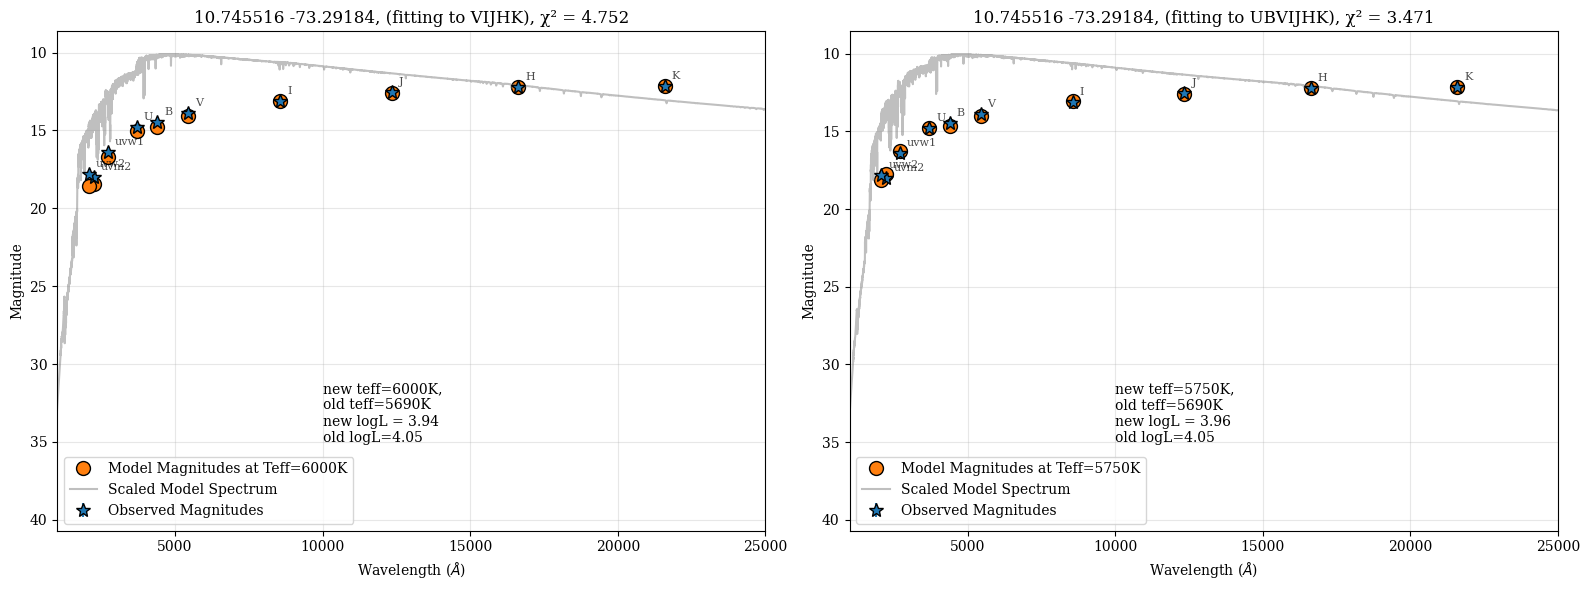

In [6]:
def fit_models_to_star(star_idx, max_models=None, show=False):   
    computed_models = pd.read_csv('synth_phot_all_models.csv')
    model_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']
    synth_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']          
    chi2_results = []
    old_teff = 10**stats['logT'][star_idx]
    old_logl = stats['logL'][star_idx]

    obs = observed_sed(star_idx, show=False)
    obs_wavelengths, obs_fluxes, obs_flux_errors, obs_mags, obs_mag_errors, obs_band_names = obs
    
    # Create dictionaries for observed data keyed by band name
    obs_mags_dict = dict(zip(obs_band_names, obs_mags))
    obs_errors_dict = dict(zip(obs_band_names, obs_mag_errors))
    
    # Find common bands between observations and model
    common_bands = [band for band in obs_band_names if band in synth_band_names]
    
    # Extract matched data arrays using band names
    matched_obs_mags = np.array([obs_mags_dict[band] for band in common_bands])
    matched_obs_errors = np.array([obs_errors_dict[band] for band in common_bands])
    
    # Define cut bands for reduced chi-squared calculation
    cut_bands = ['J', 'H', 'K', 'V', 'I']
    full_bands = ['J', 'H', 'K', 'U', 'B' 'V', 'I']
    
    # Test only bosz_smc for star_idx < 377, only lmc_bosz for star_idx >= 377:
    if star_idx < 377:
        models_to_test = computed_models[computed_models['metallicity'] == -0.75]
    else:
        models_to_test = computed_models[computed_models['metallicity'] == -0.25]

    for i, model in models_to_test.iterrows():
        matched_model_mags = np.array([model[band+'_mag'] for band in common_bands])
        
        # Determine reference band for magnitude shift (prefer K, then H, then first available)
        if 'K' in common_bands:
            ref_band = 'K'
        else:
            ref_band = 'H'
        
        ref_idx = common_bands.index(ref_band)
        mag_shift = matched_obs_mags[ref_idx] - matched_model_mags[ref_idx]
        model_mags_shifted = matched_model_mags + mag_shift


        offset = 10**(-0.4 * matched_obs_mags[ref_idx]) / 10**(-0.4 * matched_model_mags[ref_idx])
        luminosity = model['lum_unscaled'] * offset
        logL = np.log10(luminosity / 3.826e33)  # Solar luminosity in erg/s
        
        # Calculate chi-squared for full set
        # chi2_full = rchi2_with_err(matched_obs_mags, matched_obs_errors, model_mags_shifted)
        
        # Calculate chi-squared for cut bands (J, H, K, V, I only)
        cut_indices = [j for j, band in enumerate(common_bands) if band in cut_bands]
        full_indices = [h for h, band in enumerate(common_bands) if band in full_bands]
        chi2_cut = np.nan
        chi2_full = rchi2_with_err(matched_obs_mags[full_indices], 
                                matched_obs_errors[full_indices], 
                                model_mags_shifted[full_indices])
        
        chi2_cut = rchi2_with_err(matched_obs_mags[cut_indices], 
                                matched_obs_errors[cut_indices], 
                                model_mags_shifted[cut_indices])
        chi2_results.append({
            'teff': model['teff'],
            'logT': np.log10(model['teff']),
            'logg': model['logg'],
            'av': model['av'],
            'metallicity': model['metallicity'],
            'chi2_full': chi2_full,
            'chi2_cut': chi2_cut,
            'n_bands': len(common_bands),
            'ref_band': ref_band,
            'mag_shift': mag_shift,
            'offset': offset,
            'luminosity': luminosity,
            'logL': logL,
            'filepath': model['model']
        })
    chi2_results_full = sorted(chi2_results, key=lambda x: x['chi2_full'])
    chi2_results_cut = sorted(chi2_results, key=lambda x: x['chi2_cut'] if not np.isnan(x['chi2_cut']) else float('inf'))
    if show:
        # Store data for both models
        plot_data = []
        
        for model in [chi2_results_cut[0], chi2_results_full[0]]:
            # Plot best fit
            best_model = model
            # Load best model spectrum
            best_model_spectrum = ascii.read(best_model['filepath'], names=['flux','cont'], data_start=0)
            best_model_flux = Cardelli_redden(wave['wave'], best_model_spectrum['flux'], Av=best_model['av'])
            # Calculate synthetic photometry for all bands using the best model
            best_model_mags_calc = [
                synth_mag(tmass_j, wave['wave'], best_model_flux, tmass_j_zp),      # J
                synth_mag(tmass_h, wave['wave'], best_model_flux, tmass_h_zp),      # H  
                synth_mag(tmass_k, wave['wave'], best_model_flux, tmass_k_zp),      # K
                synth_mag(mcps_U, wave['wave'], best_model_flux, mcps_U_zp),        # U
                synth_mag(mcps_B, wave['wave'], best_model_flux, mcps_B_zp),        # B
                synth_mag(mcps_V, wave['wave'], best_model_flux, mcps_V_zp),        # V
                synth_mag(mcps_I, wave['wave'], best_model_flux, mcps_I_zp),        # I
                synth_mag(swift_uvm1, wave['wave'], best_model_flux, swift_uvm1_zp), # uvm2
                synth_mag(swift_uvw1, wave['wave'], best_model_flux, swift_uvw1_zp), # uvw1
                synth_mag(swift_uvw2, wave['wave'], best_model_flux, swift_uvw2_zp)  # uvw2
            ]
            # Create model magnitudes dictionary for best model
            best_model_mags_dict = dict(zip(model_band_names, best_model_mags_calc))
            # find common bands between observations and best model 
            best_common_bands = [band for band in obs_band_names if band in best_model_mags_dict]
            # Extract matched data arrays using band names
            plot_matched_obs_mags = np.array([obs_mags_dict[band] for band in best_common_bands])
            plot_matched_obs_errors = np.array([obs_errors_dict[band] for band in best_common_bands])  
            plot_matched_model_mags = np.array([best_model_mags_dict[band] for band in best_common_bands])

            plot_ref_band = 'K'
                
            plot_ref_idx = best_common_bands.index(plot_ref_band)
            plot_mag_shift = plot_matched_obs_mags[plot_ref_idx] - plot_matched_model_mags[plot_ref_idx]
            plot_model_mags_shifted = plot_matched_model_mags + plot_mag_shift
            plot_matched_wavelengths = [band_wavelengths[band] for band in best_common_bands]

            offset = 10**(-0.4 * matched_obs_mags[ref_idx]) / 10**(-0.4 * matched_model_mags[ref_idx])
            newflux = best_model_flux * offset
            luminosity = best_model['luminosity']  # Use the pre-calculated luminosity from chi2_results
            logL = best_model['logL']  # Use the pre-calculated logL from chi2_results

            # convert all to flux for plotting
            
            
            # chi-squared for the plot title
            plot_chi2 = rchi2_with_err(plot_matched_obs_mags[full_indices], plot_matched_obs_errors[full_indices], plot_model_mags_shifted[full_indices])
            plot_chi2_cut = rchi2_with_err(plot_matched_obs_mags[cut_indices], 
                                        plot_matched_obs_errors[cut_indices], 
                                        plot_model_mags_shifted[cut_indices])
            
            # Store all the data needed for plotting
            plot_data.append({
                'best_model': best_model,
                'plot_matched_obs_mags': plot_matched_obs_mags,
                'plot_matched_obs_errors': plot_matched_obs_errors,
                'plot_model_mags_shifted': plot_model_mags_shifted,
                'plot_matched_wavelengths': plot_matched_wavelengths,
                'best_common_bands': best_common_bands,
                'newflux': newflux,
                'luminosity': luminosity,
                'logL': logL,
                'plot_chi2': plot_chi2,
                'plot_chi2_cut': plot_chi2_cut
            })
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
        RA = coords['RA'].iloc[star_idx]
        dec = coords['DEC'].iloc[star_idx]
        
        # Plot cut bands model
        data_cut = plot_data[0]
        ax1.errorbar(obs_wavelengths, obs_mags, yerr=obs_mag_errors,
                    ms=10, fmt='*', mec='k', mfc='C0', ecolor='C0', label='Observed Magnitudes')
        ax1.plot(data_cut['plot_matched_wavelengths'], data_cut['plot_model_mags_shifted'],
                'o', ms=10, mec='k', mfc='C1', label='Model Magnitudes at Teff={:.0f}K'.format(data_cut['best_model']['teff']))
        # Add band labels
        for i, (wl, mag, band) in enumerate(zip(data_cut['plot_matched_wavelengths'], 
                                            data_cut['plot_matched_obs_mags'], 
                                            data_cut['best_common_bands'])):
            ax1.annotate(band, (wl, mag), xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.7)
        ax1.plot(wave['wave'], -2.5 * np.log10(data_cut['newflux']/tmass_k_zp),
                '-', color='gray', alpha=0.5, label='Scaled Model Spectrum')
        ax1.annotate('new teff={:.0f}K, \nold teff={:.0f}K \nnew logL = {:.2f} \nold logL={:.2f}'.format(
                    data_cut['best_model']['teff'], old_teff, data_cut['logL'], old_logl), 
                    xy=(10000,35), color='black')
        ax1.set_xlabel(r'Wavelength ($\AA$)')
        ax1.set_ylabel('Magnitude')
        ax1.set_title(f'{RA} {dec}, (fitting to VIJHK), χ² = {data_cut["plot_chi2_cut"]:.3f}')
        ax1.invert_yaxis()
        ax1.set_xlim(1000,25000)
        ax1.legend(loc='best')
        ax1.grid(True, alpha=0.3)
        
        # Plot full bands model
        data_full = plot_data[1]
        ax2.errorbar(obs_wavelengths, obs_mags, yerr=obs_mag_errors,
                    ms=10, fmt='*', mec='k', mfc='C0', ecolor='C0', label='Observed Magnitudes')
        ax2.plot(data_full['plot_matched_wavelengths'], data_full['plot_model_mags_shifted'],
                'o', ms=10, mec='k', mfc='C1', label='Model Magnitudes at Teff={:.0f}K'.format(data_full['best_model']['teff']))
        # Add band labels
        for i, (wl, mag, band) in enumerate(zip(data_full['plot_matched_wavelengths'], 
                                            data_full['plot_matched_obs_mags'], 
                                            data_full['best_common_bands'])):
            ax2.annotate(band, (wl, mag), xytext=(5, 5), textcoords='offset points', 
                        fontsize=8, alpha=0.7)
        ax2.plot(wave['wave'], -2.5 * np.log10(data_full['newflux']/tmass_k_zp),
                '-', color='gray', alpha=0.5, label='Scaled Model Spectrum')
        ax2.annotate('new teff={:.0f}K, \nold teff={:.0f}K \nnew logL = {:.2f} \nold logL={:.2f}'.format(
                    data_full['best_model']['teff'], old_teff, data_full['logL'], old_logl), 
                    xy=(10000,35), color='black')
        
        # ax2.plot(tmass_j['lam'],tmass_j['flux']*np.mean(points_flux),
        # '--',c='yellow',label='J Filter')
        # ax2.plot(tmass_h['lam'],tmass_h['flux']*np.mean(points_flux),
        #         '--',c='orange',label='H Filter')
        # ax2.plot(tmass_k['lam'],tmass_k['flux']*np.mean(points_flux),
        #         '--',c='red',label='K Filter')
        # ax2.plot(mcps_B['lam'],mcps_B['flux']*np.mean(points_flux),
        #         '--',c='green',label='B Filter')
        # ax2.plot(mcps_V['lam'],mcps_V['flux']*np.mean(points_flux),
        #         '--',c='blue',label='V Filter')
        # ax2.plot(mcps_I['lam'],mcps_I['flux']*np.mean(points_flux),
        #         '--',c='purple',label='I Filter')
        # ax2.plot(swift_uvm1['lam'],swift_uvm1['flux']*np.mean(points_flux),
        #         '--',c='pink',label='UVM1 Filter')
        # ax2.plot(swift_uvw1['lam'],swift_uvw1['flux']*np.mean(points_flux),
        #         '--',c='brown',label='UVW1 Filter')
        # ax2.plot(swift_uvw2['lam'],swift_uvw2['flux']*np.mean(points_flux),
        #         '--',c='gray',label='UVW2 Filter')

        ax2.set_xlabel(r'Wavelength ($\AA$)')
        ax2.set_ylabel('Magnitude')
        ax2.set_title(f'{RA} {dec}, (fitting to UBVIJHK), χ² = {data_full["plot_chi2"]:.3f}')
        ax2.invert_yaxis()
        ax2.set_xlim(1000,25000)
        ax2.legend(loc='best')
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()

    
fit_models_to_star(star_idx=23, show=True)

DEBUG: Star index 302
DEBUG: Target FULL parameters - Teff: 10250.0, logg: 2.0, av: 1.0, metallicity: -0.75
DEBUG: Target CUT parameters - Teff: 6750.0, logg: 2.0, av: 0.0, metallicity: -0.75
DEBUG: Total models in computed_models: 2662
DEBUG: Computed models columns: ['model', 'teff', 'logg', 'atmos', 'metallicity', 'av', 'lum_unscaled', 'J_mag', 'H_mag', 'K_mag', 'U_mag', 'B_mag', 'V_mag', 'I_mag', 'uvm2_mag', 'uvw1_mag', 'uvw2_mag', 'J_flux', 'H_flux', 'K_flux', 'U_flux', 'B_flux', 'V_flux', 'I_flux', 'uvm2_flux', 'uvw1_flux', 'uvw2_flux']
DEBUG: Unique Teff values in models: [np.int64(4000), np.int64(4250), np.int64(4500), np.int64(4750), np.int64(5000), np.int64(5250), np.int64(5500), np.int64(5750), np.int64(6000), np.int64(6250), np.int64(6500), np.int64(6750), np.int64(7000), np.int64(7250), np.int64(7500), np.int64(7750), np.int64(8000), np.int64(8250), np.int64(8500), np.int64(8750), np.int64(9000), np.int64(9250), np.int64(9500), np.int64(9750), np.int64(10000), np.int64(102

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/750665723.py:272: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax.set_ylim(bottom=np.log10(y_min))


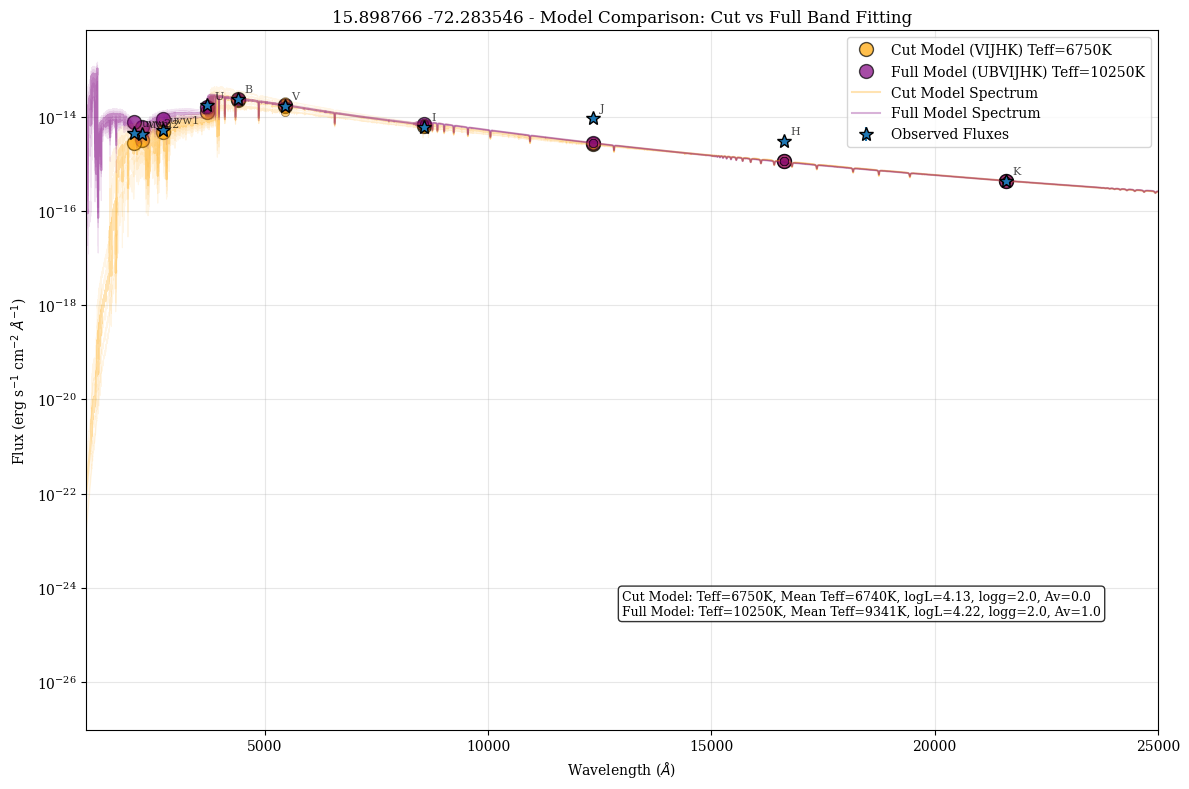

[{'model_type': 'cut',
  'model': model           /Users/shannonbowes/Research/ysg/candidates_an...
  teff                                                         6750
  logg                                                          2.0
  atmos                                                          ms
  metallicity                                                 -0.75
  av                                                            0.0
  lum_unscaled    4321628179508296007977116752627097127996051389...
  J_mag                                                  -37.124848
  H_mag                                                  -37.312402
  K_mag                                                  -37.326127
  U_mag                                                  -36.024526
  B_mag                                                  -36.178986
  V_mag                                                   -36.46144
  I_mag                                                  -36.900977
  uvm2_mag      

In [ ]:
def fit_models_to_star_flux(star_idx, max_models=None, show=False):   
    computed_models = pd.read_csv('synth_phot_all_models.csv')
    model_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']
    synth_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']          
    chi2_results = []
    old_teff = 10**stats['logT'][star_idx]
    old_logl = stats['logL'][star_idx]

    obs = observed_sed(star_idx, show=False)
    obs_wavelengths, obs_fluxes, obs_flux_errors, obs_mags, obs_mag_errors, obs_band_names = obs
    
    # Create dictionaries for observed data keyed by band name
    obs_mags_dict = dict(zip(obs_band_names, obs_mags))
    obs_errors_dict = dict(zip(obs_band_names, obs_mag_errors))
    
    # Since synth_band_names always contains all obs bands, use obs_band_names directly
    matched_obs_mags = np.array([obs_mags_dict[band] for band in obs_band_names])
    matched_obs_errors = np.array([obs_errors_dict[band] for band in obs_band_names])
    matched_obs_fluxes = np.array([obs_fluxes[i] for i, band in enumerate(obs_band_names)])
    matched_obs_flux_errors = np.array([obs_flux_errors[i] for i, band in enumerate(obs_band_names)])
    common_bands = list(obs_band_names)  # Convert to list to ensure .index() method works

    # determine the best fitting model to test based on medians in ysg_temp_fitting_summary_v2.csv
    # Best fitting full parameters:
    median_teff_full = temp_stats['teff_median_full'][star_idx]
    median_logg_full = temp_stats['logg_median_full'][star_idx]
    median_av_full = temp_stats['av_median_full'][star_idx]
    median_metallicity = -0.75 if star_idx < 377 else -0.25
    #Best fitting cut parameters:
    median_teff_cut = temp_stats['teff_median_cut'][star_idx]
    median_logg_cut = temp_stats['logg_median_cut'][star_idx]
    median_av_cut = temp_stats['av_median_cut'][star_idx]

    # DEBUG: Print the target parameters
    print(f"DEBUG: Star index {star_idx}")
    print(f"DEBUG: Target FULL parameters - Teff: {median_teff_full}, logg: {median_logg_full}, av: {median_av_full}, metallicity: {median_metallicity}")
    print(f"DEBUG: Target CUT parameters - Teff: {median_teff_cut}, logg: {median_logg_cut}, av: {median_av_cut}, metallicity: {median_metallicity}")
    
    # DEBUG: Check what's in the computed models
    print(f"DEBUG: Total models in computed_models: {len(computed_models)}")
    print(f"DEBUG: Computed models columns: {computed_models.columns.tolist()}")
    print(f"DEBUG: Unique Teff values in models: {sorted(computed_models['teff'].unique())}")
    print(f"DEBUG: Unique logg values in models: {sorted(computed_models['logg'].unique())}")
    print(f"DEBUG: Unique av values in models: {sorted(computed_models['av'].unique())}")
    print(f"DEBUG: Unique metallicity values in models: {sorted(computed_models['metallicity'].unique())}")

    # Filter models based on median parameters - separate the two model sets properly
    models_full = computed_models[
        (computed_models['teff'] == median_teff_full) &
        (computed_models['logg'] == median_logg_full) &
        (computed_models['av'] == median_av_full) &
        (computed_models['metallicity'] == median_metallicity)
    ]
    
    models_cut = computed_models[
        (computed_models['teff'] == median_teff_cut) &
        (computed_models['logg'] == median_logg_cut) &
        (computed_models['av'] == median_av_cut) &
        (computed_models['metallicity'] == median_metallicity)
    ]
    
    
    # DEBUG: Show closest matches if no exact matches found
    if len(models_full) == 0:
        print("DEBUG: Finding closest FULL matches...")
        teff_diff = np.abs(computed_models['teff'] - median_teff_full)
        logg_diff = np.abs(computed_models['logg'] - median_logg_full)
        av_diff = np.abs(computed_models['av'] - median_av_full)
        closest_full = computed_models.loc[teff_diff.idxmin()]
        print(f"DEBUG: Closest Teff match: {closest_full['teff']} (target: {median_teff_full})")
        print(f"DEBUG: Closest logg match: {computed_models.loc[logg_diff.idxmin(), 'logg']} (target: {median_logg_full})")
        print(f"DEBUG: Closest av match: {computed_models.loc[av_diff.idxmin(), 'av']} (target: {median_av_full})")
    
    if len(models_cut) == 0:
        print("DEBUG: Finding closest CUT matches...")
        teff_diff = np.abs(computed_models['teff'] - median_teff_cut)
        logg_diff = np.abs(computed_models['logg'] - median_logg_cut)
        av_diff = np.abs(computed_models['av'] - median_av_cut)
        closest_cut = computed_models.loc[teff_diff.idxmin()]
        print(f"DEBUG: Closest Teff match: {closest_cut['teff']} (target: {median_teff_cut})")
        print(f"DEBUG: Closest logg match: {computed_models.loc[logg_diff.idxmin(), 'logg']} (target: {median_logg_cut})")
        print(f"DEBUG: Closest av match: {computed_models.loc[av_diff.idxmin(), 'av']} (target: {median_av_cut})")
    if show:
        plot_data = []
        
        # Process both models (full and cut)
        for model_type, models in [('cut', models_cut), ('full', models_full)]:
            if len(models) == 0:
                print(f"No models found for {model_type}")
                continue
                
            # Take the first (should be only) model
            model = models.iloc[0]
            
            # Load model spectrum
            model_spectrum = ascii.read(model['model'], names=['flux','cont'], data_start=0)
            model_flux = Cardelli_redden(wave['wave'], model_spectrum['flux'], Av=model['av'])
            
            # Calculate synthetic fluxes for all bands using the model
            model_fluxes_calc = [
                synth_flux(tmass_j, wave['wave'], model_flux),      # J
                synth_flux(tmass_h, wave['wave'], model_flux),      # H  
                synth_flux(tmass_k, wave['wave'], model_flux),      # K
                synth_flux(mcps_U, wave['wave'], model_flux),        # U
                synth_flux(mcps_B, wave['wave'], model_flux),        # B
                synth_flux(mcps_V, wave['wave'], model_flux),        # V
                synth_flux(mcps_I, wave['wave'], model_flux),        # I
                synth_flux(swift_uvm1, wave['wave'], model_flux), # uvm2
                synth_flux(swift_uvw1, wave['wave'], model_flux), # uvw1
                synth_flux(swift_uvw2, wave['wave'], model_flux)  # uvw2
            ]
            
            # Create model fluxes dictionary
            model_fluxes_dict = dict(zip(model_band_names, model_fluxes_calc))
            
            # Get matched synthetic fluxes for common bands
            matched_model_fluxes = np.array([model_fluxes_dict[band] for band in common_bands])
            
            # Determine reference band for flux scaling (prefer K, then H)
            if 'K' in common_bands:
                ref_band = 'K'
            else:
                ref_band = 'H'
            
            ref_idx = common_bands.index(ref_band)
            
            # Calculate scaling factor using reference band
            flux_scale = matched_obs_fluxes[ref_idx] / matched_model_fluxes[ref_idx]
            
            # Scale model fluxes and spectrum
            scaled_model_fluxes = matched_model_fluxes * flux_scale
            scaled_model_spectrum = model_flux * flux_scale
            
            # Calculate luminosity from scaling
            luminosity = model['lum_unscaled'] * flux_scale
            logL = np.log10(luminosity / 3.826e33)  # Solar luminosity in erg/s
            
            # Get wavelengths for plotting
            plot_wavelengths = [band_wavelengths[band] for band in common_bands]
            
            # Store data for plotting
            plot_data.append({
                'model_type': model_type,
                'model': model,
                'scaled_model_fluxes': scaled_model_fluxes,
                'scaled_model_spectrum': scaled_model_spectrum,
                'plot_wavelengths': plot_wavelengths,
                'common_bands': common_bands,
                'matched_obs_fluxes': matched_obs_fluxes,
                'logL': logL,
                'luminosity': luminosity
            })


        fig, ax = plt.subplots(1, 1, figsize=(12, 8))
        RA = coords['RA'].iloc[star_idx]
        dec = coords['DEC'].iloc[star_idx]
        
        # Plot observed data points once
        ax.errorbar(obs_wavelengths, obs_fluxes, yerr=obs_flux_errors,
                   ms=10, fmt='*', mec='k', mfc='C0', ecolor='C0', label='Observed Fluxes')
        
        # Plot cut bands model (first in plot_data) 
        data_cut = plot_data[0]  # This should be the 'cut' model
        ax.plot(data_cut['plot_wavelengths'], data_cut['scaled_model_fluxes'],
               'o', ms=10, mec='k', mfc='orange', alpha=0.7, label='Cut Model (VIJHK) Teff={:.0f}K'.format(data_cut['model']['teff']))
        
        # Plot full bands model (second in plot_data)
        data_full = plot_data[1]  # This should be the 'full' model
        ax.plot(data_full['plot_wavelengths'], data_full['scaled_model_fluxes'],
               'o', ms=10, mec='k', mfc='purple', alpha=0.7, label='Full Model (UBVIJHK) Teff={:.0f}K'.format(data_full['model']['teff']))
        
        # Add band labels for observed points
        for i, (wl, flux, band) in enumerate(zip(obs_wavelengths, obs_fluxes, obs_band_names)):
            ax.annotate(band, (wl, flux), xytext=(5, 5), textcoords='offset points', 
                       fontsize=8, alpha=0.7)
        
        # Plot model spectra in background
        ax.plot(wave['wave'], data_cut['scaled_model_spectrum'],
               '-', color='orange', alpha=0.3, label='Cut Model Spectrum')
        ax.plot(wave['wave'], data_full['scaled_model_spectrum'],
               '-', color='purple', alpha=0.3, label='Full Model Spectrum')
        
        # Plot additional models within ±500K range
        for model_type, main_data, color in [('cut', data_cut, 'orange'), ('full', data_full, 'purple')]:
            best_teff = main_data['model']['teff']
            best_logg = main_data['model']['logg']
            best_av = main_data['model']['av']
            teff_range = 500
            
            # Filter models within ±500K of best fit, keeping same logg and av
            temp_models = computed_models[
                (np.abs(computed_models['teff'] - best_teff) <= teff_range) &
                (computed_models['teff'] != best_teff) &  # Exclude the main model
                (computed_models['logg'] == best_logg) &  # Same surface gravity
                (computed_models['av'] == best_av)        # Same extinction
            ]
            
            # Limit to 3-5 models to avoid clutter
            temp_models = temp_models.head(5)
            
            for r, temp_model in temp_models.iterrows():
                try:
                    # Load and process temperature variant model
                    temp_spectrum = ascii.read(temp_model['model'], names=['flux','cont'], data_start=0)
                    temp_flux = Cardelli_redden(wave['wave'], temp_spectrum['flux'], Av=temp_model['av'])
                    
                    # Calculate fluxes for the same bands as main model
                    if model_type == 'cut':
                        common_bands = ['V', 'I', 'J', 'H', 'K']
                    else:
                        common_bands = ['U', 'B', 'V', 'I', 'J', 'H', 'K']
                    
                    temp_model_fluxes = []
                    for band in common_bands:
                        if band == 'J':
                            temp_model_fluxes.append(synth_flux(tmass_j, wave['wave'], temp_flux))
                        elif band == 'H':
                            temp_model_fluxes.append(synth_flux(tmass_h, wave['wave'], temp_flux))
                        elif band == 'K':
                            temp_model_fluxes.append(synth_flux(tmass_k, wave['wave'], temp_flux))
                        elif band == 'U':
                            temp_model_fluxes.append(synth_flux(mcps_U, wave['wave'], temp_flux))
                        elif band == 'B':
                            temp_model_fluxes.append(synth_flux(mcps_B, wave['wave'], temp_flux))
                        elif band == 'V':
                            temp_model_fluxes.append(synth_flux(mcps_V, wave['wave'], temp_flux))
                        elif band == 'I':
                            temp_model_fluxes.append(synth_flux(mcps_I, wave['wave'], temp_flux))
                    
                    temp_model_fluxes = np.array(temp_model_fluxes)
                    
                    # Scale using same reference band as main model
                    ref_band = 'K' if 'K' in common_bands else 'H'
                    ref_idx = common_bands.index(ref_band)
                    main_ref_idx = main_data['common_bands'].index(ref_band)
                    obs_ref_flux = main_data['matched_obs_fluxes'][main_ref_idx]
                    temp_flux_scale = obs_ref_flux / temp_model_fluxes[ref_idx]
                    
                    # Scale and plot
                    temp_scaled_fluxes = temp_model_fluxes * temp_flux_scale
                    temp_plot_wavelengths = [band_wavelengths[band] for band in common_bands]
                    
                    ax.plot(temp_plot_wavelengths, temp_scaled_fluxes,
                           'o', ms=6, mec='k', mfc=color, alpha=0.3, markeredgewidth=0.5)
                    
                    # Also plot the scaled spectrum with very light alpha
                    temp_scaled_spectrum = temp_flux * temp_flux_scale
                    ax.plot(wave['wave'], temp_scaled_spectrum,
                           '-', color=color, alpha=0.1, linewidth=0.8)
                    
                except Exception as e:
                    print(f"Warning: Could not process temperature variant model {temp_model['teff']}K: {e}")
                    continue
        
        # Add annotation with both model parameters
        annotation_text = ('Cut Model: Teff={:.0f}K, Mean Teff={:.0f}K, logL={:.2f}, logg={:.1f}, Av={:.1f}\n'
                          'Full Model: Teff={:.0f}K, Mean Teff={:.0f}K, logL={:.2f}, logg={:.1f}, Av={:.1f}').format(
                          data_cut['model']['teff'], temp_stats.iloc[star_idx]['teff_mean_cut'], data_cut['logL'], data_cut['model']['logg'], data_cut['model']['av'],
                          data_full['model']['teff'], temp_stats.iloc[star_idx]['teff_mean_full'], data_full['logL'], data_full['model']['logg'], data_full['model']['av'])
        
        ax.annotate(annotation_text, xy=(0.5, 0.2), xycoords='axes fraction', 
                   va='top', color='black', fontsize=9, 
                   bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        ax.set_xlabel(r'Wavelength ($\AA$)')
        ax.set_ylabel(r'Flux (erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)')
        ax.set_title(f'{RA} {dec} - Model Comparison: Cut vs Full Band Fitting')
        ax.set_xlim(1000, 25000)
        ax.set_yscale('log')
        y_min = min(np.min(data_cut['scaled_model_fluxes']), np.min(data_full['scaled_model_fluxes']))
        # ax.set_ylim(bottom=np.log10(y_min))
        ax.legend(loc='best')
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    return plot_data if show else None

fit_models_to_star_flux(star_idx=302, show=True)

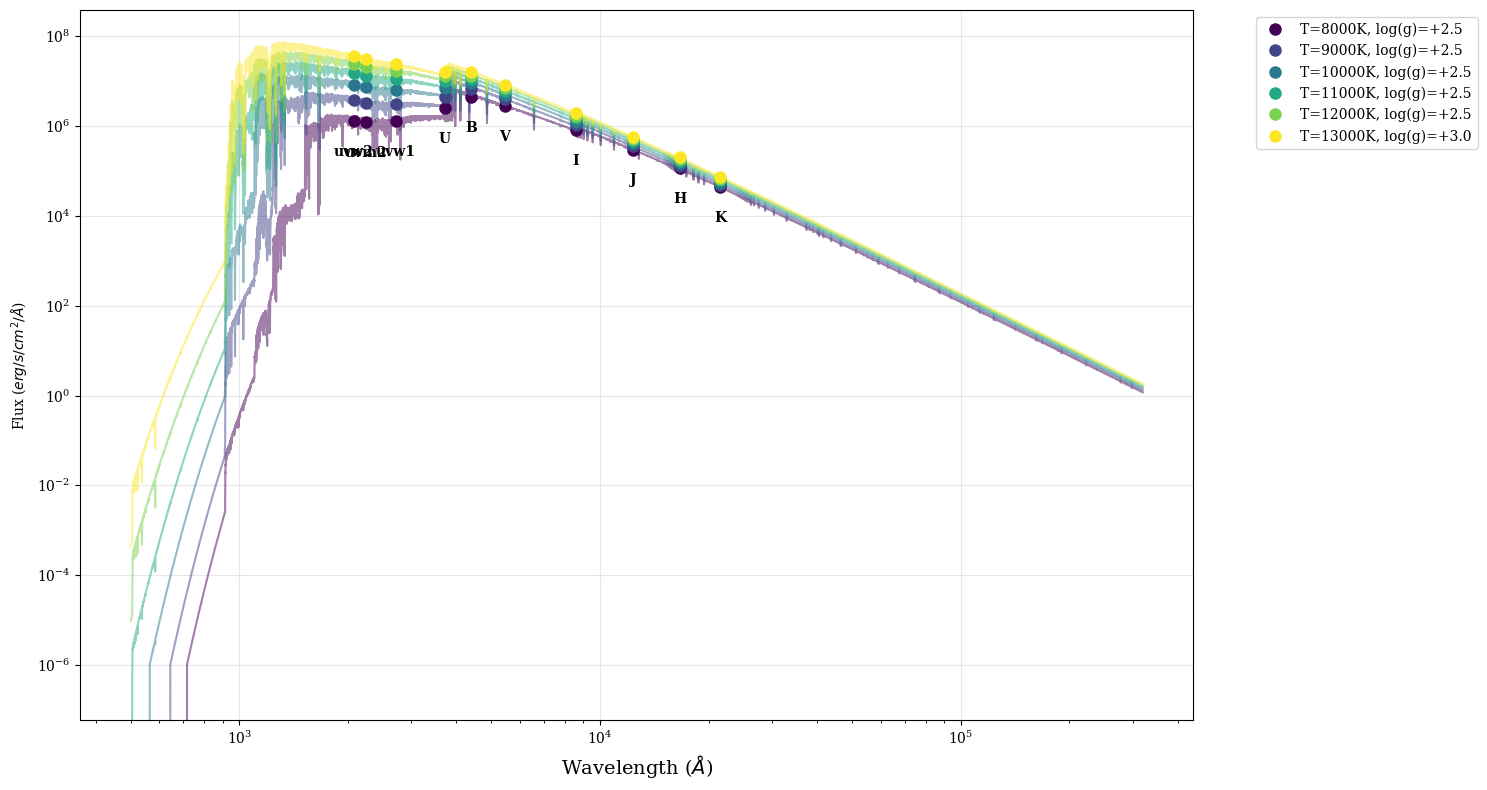

In [108]:
# filenames_to_test = [
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.75/bosz2024_ms_t7000_g+1.5_m-0.75_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.75/bosz2024_ms_t7000_g+2.0_m-0.75_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.75/bosz2024_ms_t7000_g+2.5_m-0.75_a+0.00_c+0.00_v2_r2000_resam.txt.gz']
# Calculate synthetic photometry for your 3 magnitudes
def compute_synth_photometry(ex_wave, ex_flux):
    jmag=synth_mag(tmass_j,ex_wave['wave'],ex_flux['flux'],tmass_j_zp)
    hmag=synth_mag(tmass_h,ex_wave['wave'],ex_flux['flux'],tmass_h_zp)
    kmag=synth_mag(tmass_k,ex_wave['wave'],ex_flux['flux'],tmass_k_zp)
    Umag=synth_mag(mcps_U,ex_wave['wave'],ex_flux['flux'],mcps_U_zp)
    Bmag=synth_mag(mcps_B,ex_wave['wave'],ex_flux['flux'],mcps_B_zp)
    Vmag=synth_mag(mcps_V,ex_wave['wave'],ex_flux['flux'],mcps_V_zp)
    Imag=synth_mag(mcps_I,ex_wave['wave'],ex_flux['flux'],mcps_I_zp)
    uvm2_mag=synth_mag(swift_uvm1,ex_wave['wave'],ex_flux['flux'],swift_uvm1_zp)
    uvw1_mag=synth_mag(swift_uvw1,ex_wave['wave'],ex_flux['flux'],swift_uvw1_zp)
    uvw2_mag=synth_mag(swift_uvw2,ex_wave['wave'],ex_flux['flux'],swift_uvw2_zp)
    model_mags=[jmag,hmag,kmag,Umag,Bmag,Vmag,Imag,uvm2_mag,uvw1_mag,uvw2_mag]

    #convert them to flux:
    jflux = tmass_j_zp * 10**(-0.4 * jmag)
    hflux = tmass_h_zp * 10**(-0.4 * hmag)
    kflux = tmass_k_zp * 10**(-0.4 * kmag)
    Uflux = mcps_U_zp * 10**(-0.4 * Umag)
    Bflux = mcps_B_zp * 10**(-0.4 * Bmag)
    Vflux = mcps_V_zp * 10**(-0.4 * Vmag)
    Iflux = mcps_I_zp * 10**(-0.4 * Imag)
    uvm2_flux = swift_uvm1_zp * 10**(-0.4 * uvm2_mag)
    uvw1_flux = swift_uvw1_zp * 10**(-0.4 * uvw1_mag)
    uvw2_flux = swift_uvw2_zp * 10**(-0.4 * uvw2_mag)
    model_fluxes=[jflux,hflux,kflux,Uflux,Bflux,Vflux,Iflux,uvm2_flux,uvw1_flux,uvw2_flux]

    # dictionary with band names as keys
    synth_phot = {
        'J': {'mag': jmag, 'flux': jflux},
        'H': {'mag': hmag, 'flux': hflux},
        'K': {'mag': kmag, 'flux': kflux},
        'U': {'mag': Umag, 'flux': Uflux},
        'B': {'mag': Bmag, 'flux': Bflux},
        'V': {'mag': Vmag, 'flux': Vflux},
        'I': {'mag': Imag, 'flux': Iflux},
        'uvm2': {'mag': uvm2_mag, 'flux': uvm2_flux},
        'uvw1': {'mag': uvw1_mag, 'flux': uvw1_flux},
        'uvw2': {'mag': uvw2_mag, 'flux': uvw2_flux}
    }

    return synth_phot

# filenames_to_test = [
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+0.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+0.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+1.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+1.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+2.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
#     '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ms_t4000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz']


filenames_to_test = [
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t8000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t9000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t10000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t11000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t12000_g+2.5_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz',
    '/Users/shannonbowes/Research/ysg/candidates_and_lcs/2022_asassn_lc_data/pysynphot_data/grid/bosz/r2000/m-0.25/bosz2024_ap_t13000_g+3.0_m-0.25_a+0.00_c+0.00_v2_r2000_resam.txt.gz']

# Define the correct order and names to match compute_synth_photometry output
synth_band_names = ['J', 'H', 'K', 'U', 'B', 'V', 'I', 'uvm2', 'uvw1', 'uvw2']
synth_wavelengths = [band_wavelengths[band] for band in synth_band_names]

fig, ax = plt.subplots(figsize=(15, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(filenames_to_test)))

# Store first model's magnitudes for band labeling
first_model_mags = None
first_model_flux = None

for i, model in enumerate(filenames_to_test):
    data = np.loadtxt(model)
    # Create a dictionary-like structure that the function expects
    flux_data = {'flux': data[:,0]}
    synth_phot = compute_synth_photometry(wave, flux_data) 
    points_mag = [synth_phot[band]['mag'] for band in synth_band_names]
    points_flux = [synth_phot[band]['flux'] for band in synth_band_names]
    
    # Store first model's magnitudes for consistent band labeling
    if i == 0:
        first_model_mags = points_mag
        first_model_flux = points_flux
    
    # Parse model parameters from filename for label
    import re
    match = re.search(r't(\d+)_g([+-]?\d+\.?\d*)', os.path.basename(model))
    if match:
        teff = match.group(1)
        logg = match.group(2)
        model_label = f'T={teff}K, log(g)={logg}'
    else:
        model_label = os.path.basename(model)
   # Scale the flux to be comparable to the magnitude range
    ax.plot(wave['wave'], flux_data['flux'], color=colors[i], alpha=0.5) 
    # Plot with correct wavelength-magnitude pairs
#     ax.plot(synth_wavelengths, points_mag, 'o', color=colors[i], 
#             label=model_label, markersize=8, linewidth=2, alpha=0.8)
    ax.plot(synth_wavelengths, points_flux, 'o', color=colors[i], 
            label=model_label, markersize=8, linewidth=2, zorder = 10)
    # Add band name labels only once, using the first model's positions
for j, (wl, mag, band) in enumerate(zip(synth_wavelengths, first_model_mags, synth_band_names)):
    ax.annotate(band, (wl, mag), xytext=(20, 5), textcoords='offset points', 
               fontsize=10, ha='center', fontweight='bold')
for j, (wl, mag, band) in enumerate(zip(synth_wavelengths, first_model_flux, synth_band_names)):
    ax.annotate(band, (wl, mag), xytext=(0, -25), textcoords='offset points', 
               fontsize=10, ha='center', fontweight='bold')
# for j, (wl, mag, band) in enumerate(zip(synth_wavelengths, first_model_flux, synth_band_names)):
#     ax.annotate(band, (wl, mag), xytext=(20, 45), textcoords='offset points', 
#                fontsize=10, ha='center', fontweight='bold')
# for i in 

ax.set_xlabel('Wavelength ($\\AA$)', fontsize=14)
# ax.set_ylabel('Magnitude', fontsize=14)
ax.set_ylabel('Flux ($erg/s/cm^2/\\AA$)')
# ax.set_xlim(0,40000)
# ax.set_ylim(1e-1,1e7)
ax.set_yscale('log')
ax.set_xscale('log')
# ax.set_title('Synthetic Photometry - BOSZ Models (T=4000K, varying log(g))', fontsize=16)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax.grid(True, alpha=0.3)
# ax.invert_yaxis()  # Invert y-axis since smaller magnitudes are brighter
plt.tight_layout()
plt.show()

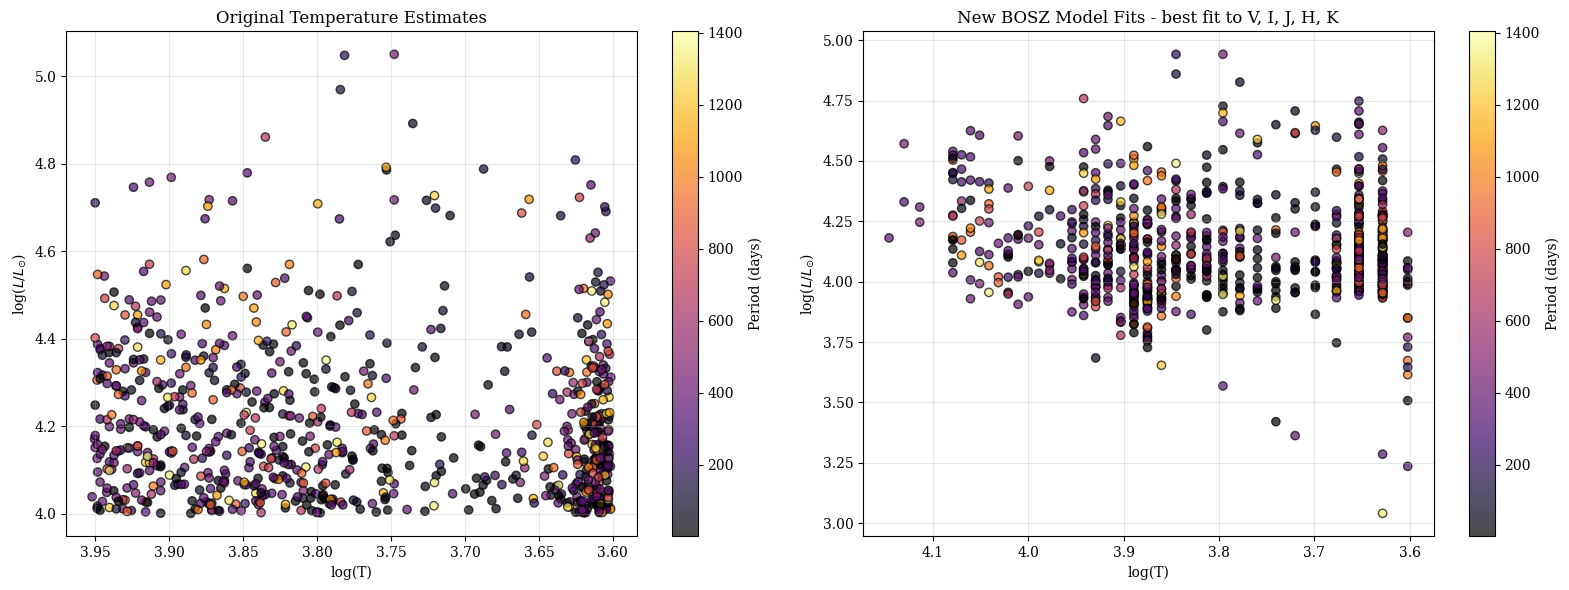

In [54]:
model_fitting = pd.read_csv('ysg_temp_fitting_results.csv')
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
sc1 = ax1.scatter(x_old, y_old, c=periods, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log(T)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
ax1.set_title('Original Temperature Estimates')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

# New estimations
x_new = model_fitting['logT_cut_1']
y_new = model_fitting['logL_cut_1']
sc2 = ax2.scatter(x_new, y_new, c=periods, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno')
ax2.set_xlabel('log(T)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
ax2.set_title('New BOSZ Model Fits - best fit to V, I, J, H, K')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)

cbar1 = plt.colorbar(sc1, ax=ax1)
cbar1.set_label('Period (days)')
cbar2 = plt.colorbar(sc2, ax=ax2)
cbar2.set_label('Period (days)')
plt.tight_layout()
plt.show()


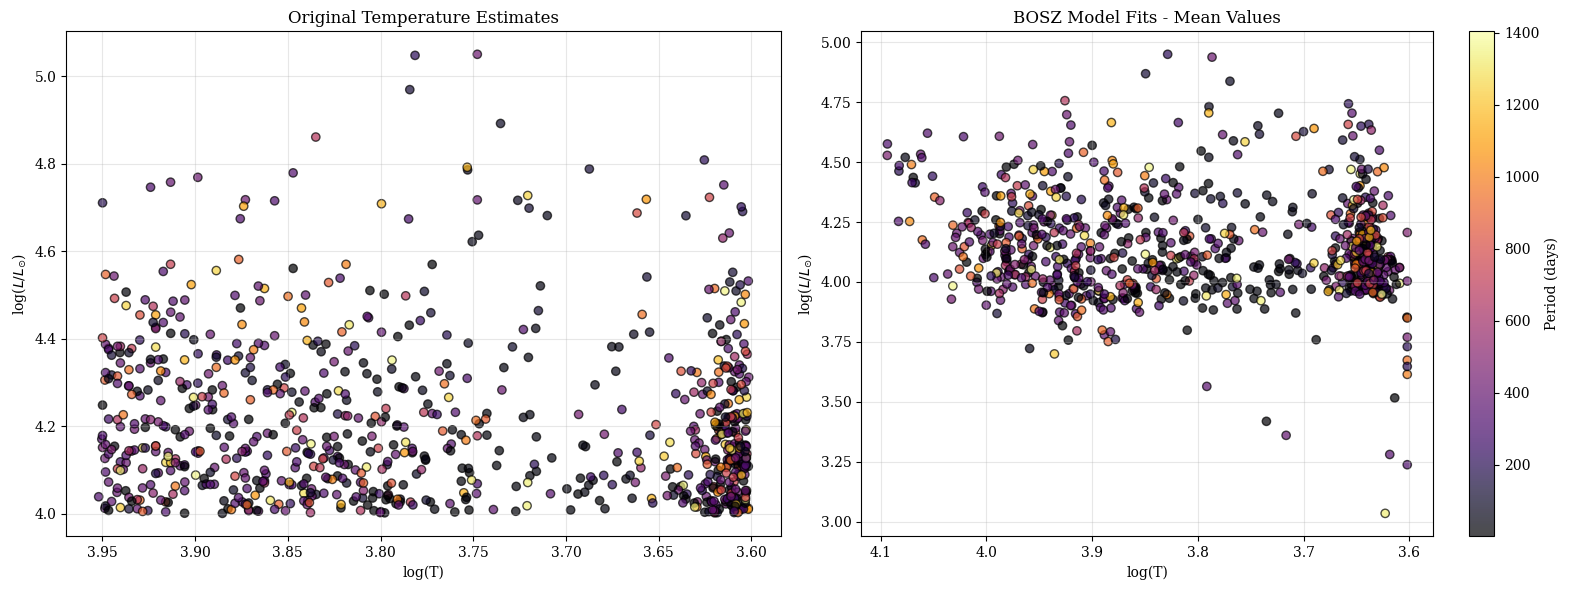

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/2549814674.py:44: UserWarning: Adding colorbar to a different Figure <Figure size 1600x600 with 4 Axes> than <Figure size 640x480 with 0 Axes> which fig.colorbar is called on.
  cbar = plt.colorbar(sc, ax=ax2)


<Figure size 640x480 with 0 Axes>

In [76]:
temp_stats = pd.read_csv('ysg_temp_fitting_summary.csv')

logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
sc1 = ax1.scatter(x_old, y_old, c=periods, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log(T)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
ax1.set_title('Original Temperature Estimates')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno')
ax2.set_xlabel('log(T)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
ax2.set_title('BOSZ Model Fits - Mean Values')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()


sc1 = ax1.scatter(temp_stats['logT_mean_full'], temp_stats['logL_mean_full'], c=periods, edgecolor='k', label='fitting to all bands', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log($T/K$)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
# ax1.set_title('')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='fitting to VIJHK', alpha=0.7, cmap='inferno')
ax2.set_xlabel('log($T/K$)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
# ax2.set_title('BOSZ Model Fits - Mean Values')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()

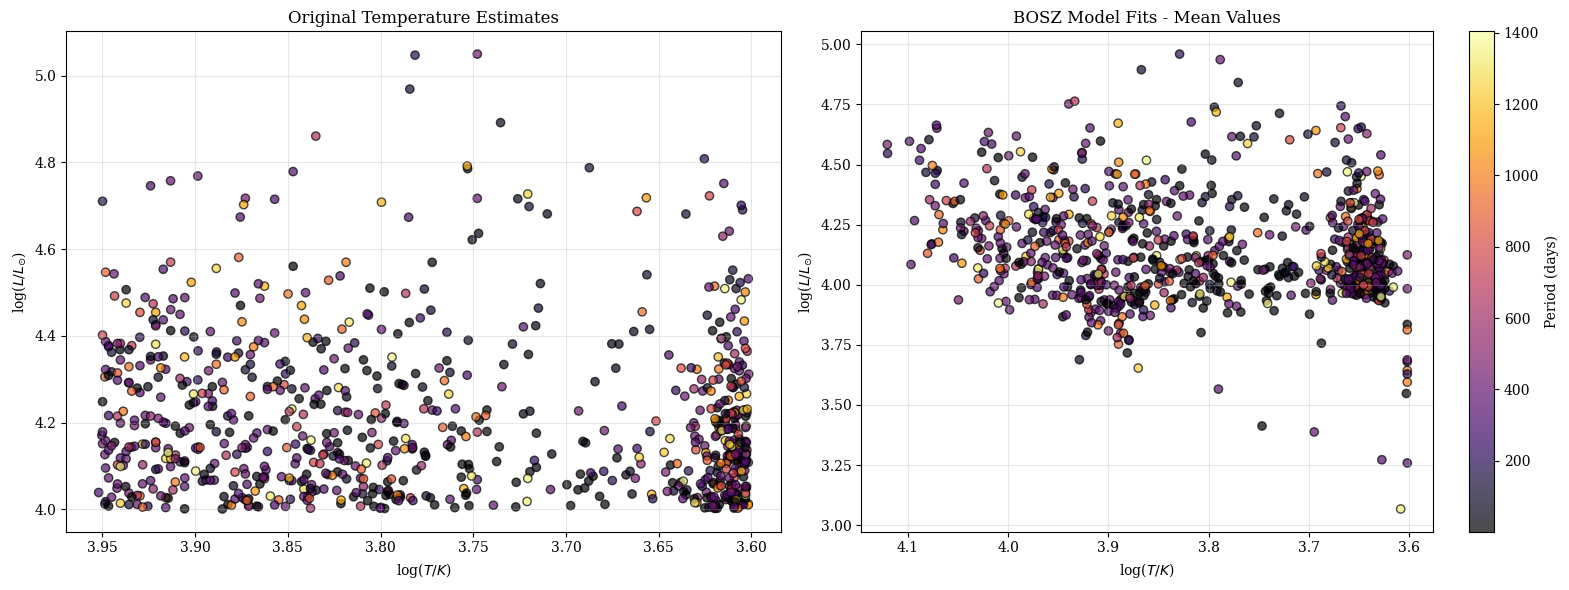

In [80]:
temp_stats = pd.read_csv('ysg_temp_fitting_summary_v2.csv')

logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
sc1 = ax1.scatter(x_old, y_old, c=periods, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log($T/K$)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
ax1.set_title('Original Temperature Estimates')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno')
ax2.set_xlabel('log($T/K$)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
ax2.set_title('BOSZ Model Fits - Mean Values')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Period (days)')
plt.tight_layout()
plt.savefig('plot.png', bbox_inches='tight')
plt.show()


# sc1 = ax1.scatter(temp_stats['logT_mean_full'], temp_stats['logL_mean_full'], c=periods, edgecolor='k', label='fitting to all bands', alpha=0.7, cmap='inferno')
# ax1.set_xlabel('log($T/K$)')
# ax1.set_ylabel('log($L/L_{\\odot}$)')
# # ax1.set_title('')
# ax1.invert_xaxis()
# ax1.grid(True, alpha=0.3)

# sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='fitting to VIJHK', alpha=0.7, cmap='inferno')
# ax2.set_xlabel('log($T/K$)')
# ax2.set_ylabel('log($L/L_{\\odot}$)')
# # ax2.set_title('BOSZ Model Fits - Mean Values')
# ax2.invert_xaxis()
# ax2.grid(True, alpha=0.3)
# cbar = plt.colorbar(sc, ax=ax2)
# cbar.set_label('Period (days)')
# plt.tight_layout()
# plt.show()

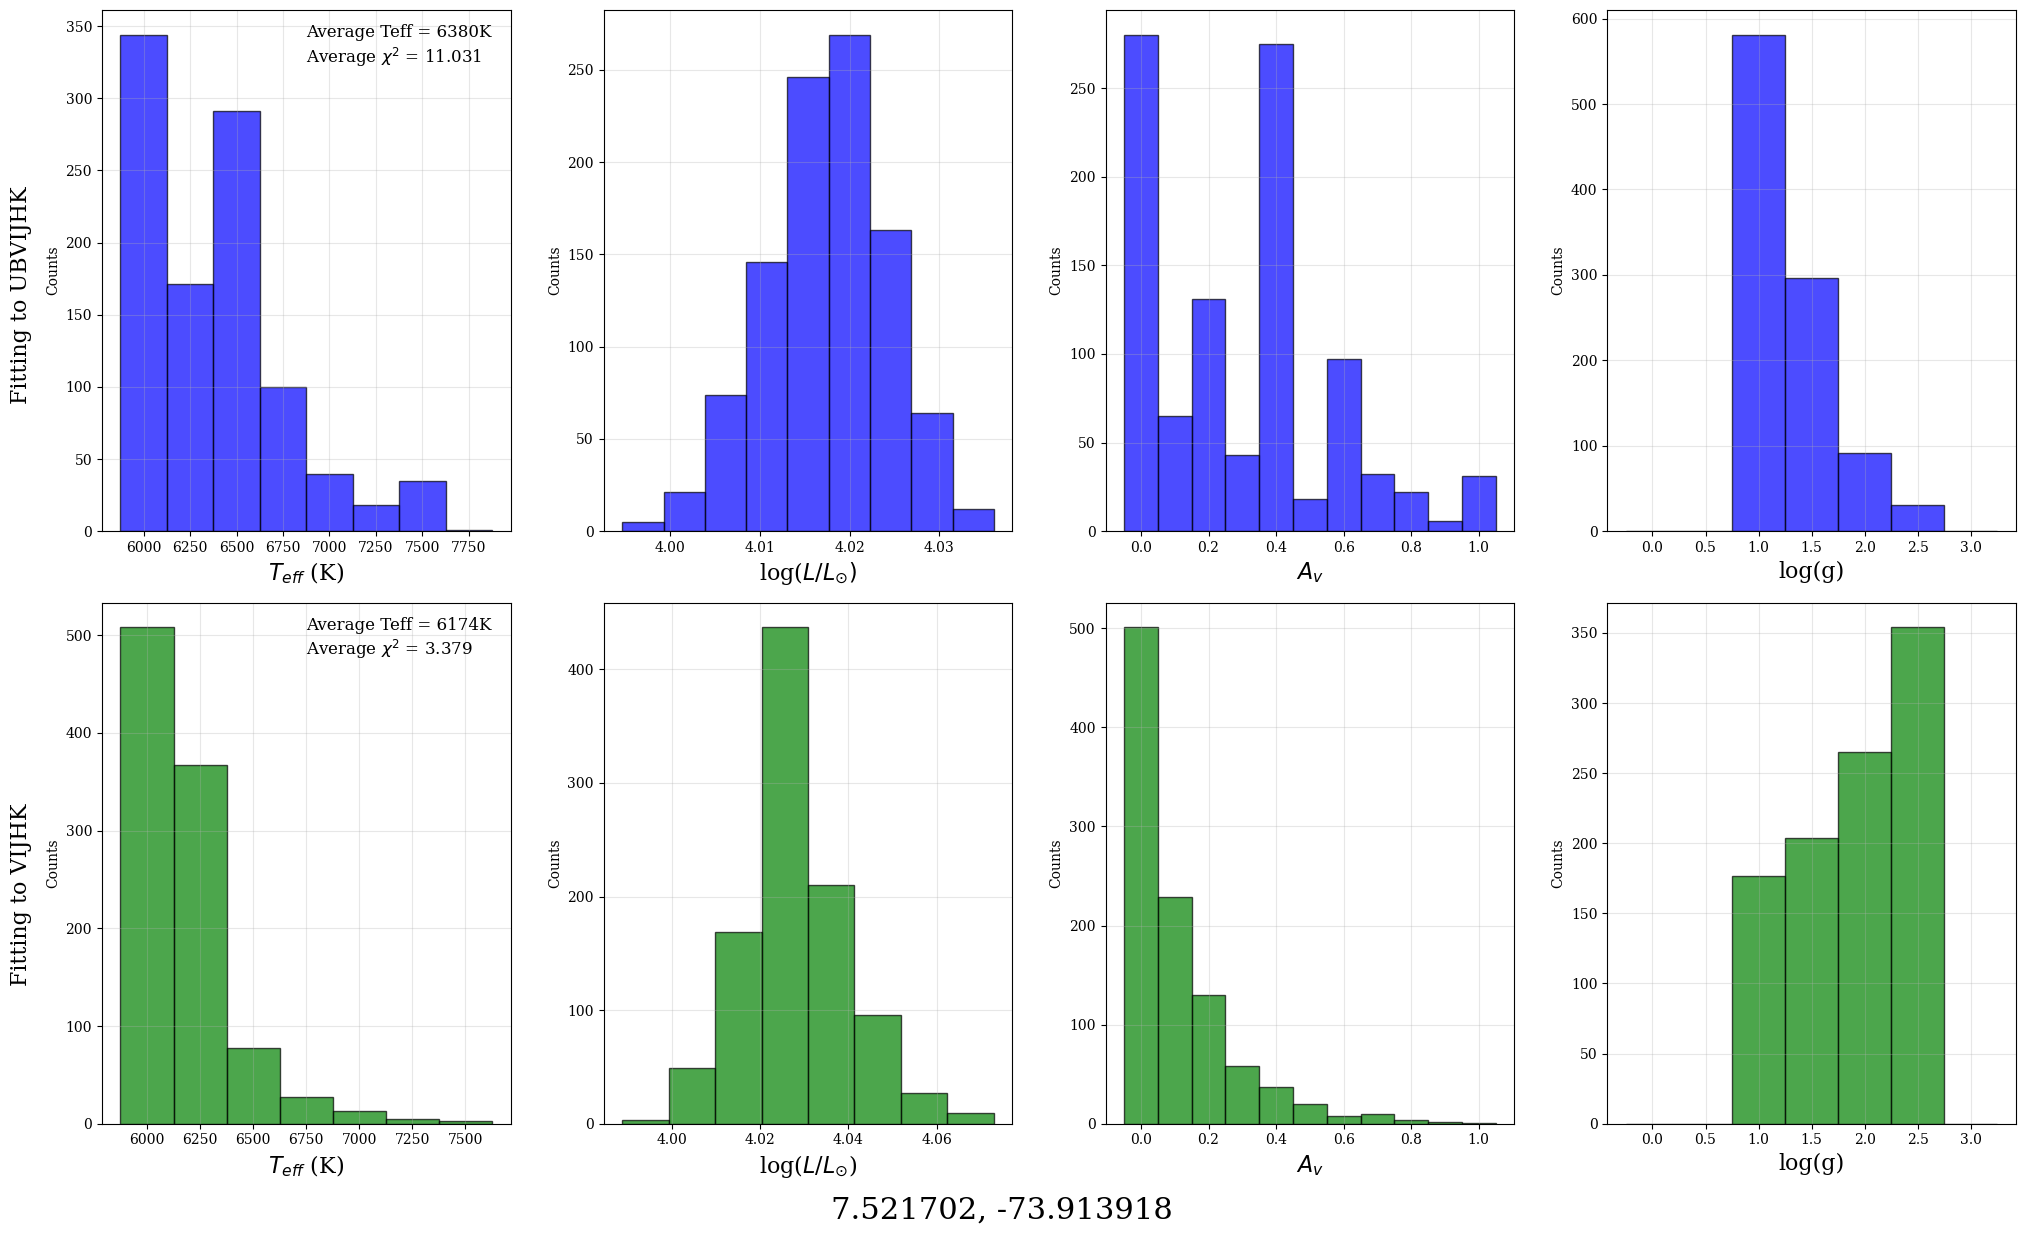

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:167: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(wave['wave'], -2.5 * np.log10(data_cut['newflux']/tmass_k_zp),
/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:192: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(wave['wave'], -2.5 * np.log10(data_full['newflux']/tmass_k_zp),


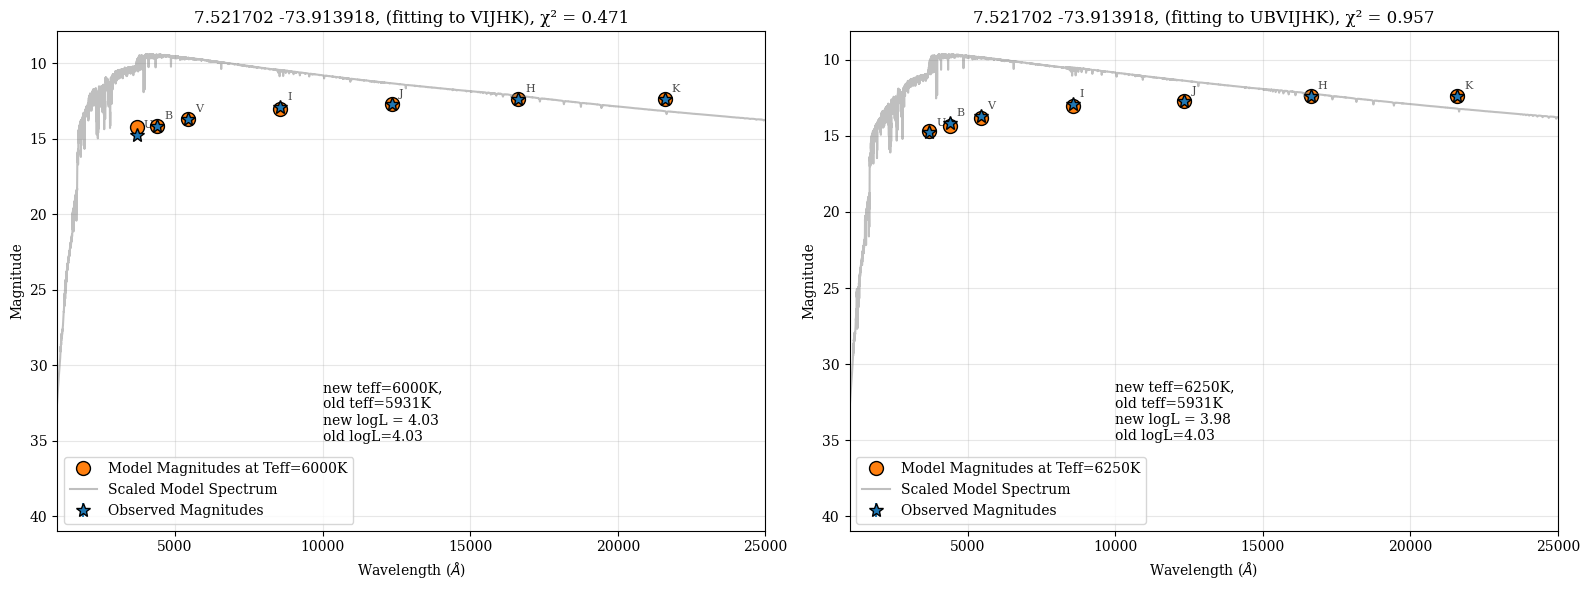

In [57]:
# # histograms for specific star:
# def histo(index):
#     RA = coords['RA'].iloc[index]
#     dec = coords['DEC'].iloc[index]
#     binwidth = 250
#     final_teff_full = temp_stats['teff_mean_full'].iloc[index]
#     final_teff_cut = temp_stats['teff_mean_cut'].iloc[index]
#     output_filename_full = f'temp_fitting/{RA}_{dec}_full.parquet'
#     output_filename_cut = f'temp_fitting/{RA}_{dec}_cut.parquet'
#     # read parquet file:
#     model_fitting_full = pd.read_parquet(output_filename_full)
#     model_fitting_cut = pd.read_parquet(output_filename_cut)
    
#     fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))
#     # Create bins that properly include the max value
#     # Add +1 to binwidth in the range to ensure the max value is included
#     bins_full = range(min(model_fitting_full['teff']) - (binwidth//2), 
#                       max(model_fitting_full['teff']) + binwidth//2 + 1, binwidth)
#     ax1.hist(model_fitting_full['teff'], bins=bins_full, color='blue', alpha=0.7, edgecolor='black')
#     ax1.annotate(f'Final Teff = {final_teff_full:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_full_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax1.set_xlabel('Teff (K)')
#     ax1.set_ylabel('Counts')
#     ax1.set_title(f'Histogram of Teff (fitting to all bands) {RA}, {dec}')
#     ax1.grid(True, alpha=0.3)

#     bins_cut = range(min(model_fitting_cut['teff']) - binwidth//2, 
#                      max(model_fitting_cut['teff']) + binwidth//2 + 1, binwidth)
#     ax2.hist(model_fitting_cut['teff'], bins=bins_cut, color='green', alpha=0.7, edgecolor='black')
#     ax2.annotate(f'Final Teff = {final_teff_cut:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_cut_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax2.set_xlabel('Teff (K)')
#     ax2.set_ylabel('Counts')
#     ax2.set_title(f'Histogram of Teff (fitting to VIJHK) {RA}, {dec}')
#     ax2.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

#     fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))
#     ax1.hist(model_fitting_full['logL'], bins=len(bins_full), color='blue', alpha=0.7, edgecolor='black')
#     # ax1.annotate(f'Final Teff = {final_teff_full:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_full_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax1.set_xlabel('logL')
#     ax1.set_ylabel('Counts')
#     ax1.set_title(f'Histogram of logL (from Teff fitting to all bands) {RA}, {dec}')
#     ax1.grid(True, alpha=0.3)

#     ax2.hist(model_fitting_cut['logL'], bins=len(bins_cut), color='green', alpha=0.7, edgecolor='black')
#     # ax2.annotate(f'Final Teff = {final_teff_cut:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_cut_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax2.set_xlabel('logL')
#     ax2.set_ylabel('Counts')
#     ax2.set_title(f'Histogram of logL (from Teff fitting to VIJHK) {RA}, {dec}')
#     ax2.grid(True, alpha=0.3)
#     plt.tight_layout()
#     plt.show()

#     fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(16, 6))
#     ax1.hist(model_fitting_full['logg'], bins=len(bins_full), color='blue', alpha=0.7, edgecolor='black')
#     # ax1.annotate(f'Final Teff = {final_teff_full:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_full_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax1.set_xlabel('logg')
#     ax1.set_ylabel('Counts')
#     ax1.set_title(f'Histogram of logg (from Teff fitting to all bands) {RA}, {dec}')
#     ax1.grid(True, alpha=0.3)

#     ax2.hist(model_fitting_cut['logg'], bins=len(bins_cut), color='green', alpha=0.7, edgecolor='black')
#     # ax2.annotate(f'Final Teff = {final_teff_cut:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_cut_mean"]:.3f}', xy=(0.7, 0.9), xycoords='axes fraction')
#     ax2.set_xlabel('logg')
#     ax2.set_ylabel('Counts')
#     ax2.set_title(f'Histogram of logg (from Teff fitting to VIJHK) {RA}, {dec}')
#     ax2.grid(True, alpha=0.3)
#     plt.tight_layout()
    # plt.show()


def histo(index):
    RA = coords['RA'].iloc[index]
    dec = coords['DEC'].iloc[index]
    binwidth = 250
    final_teff_full = temp_stats['teff_mean_full'].iloc[index]
    final_teff_cut = temp_stats['teff_mean_cut'].iloc[index]
    output_filename_full = f'temp_fitting/{RA}_{dec}_full.parquet'
    output_filename_cut = f'temp_fitting/{RA}_{dec}_cut.parquet'
    # read parquet file:
    model_fitting_full = pd.read_parquet(output_filename_full)
    model_fitting_cut = pd.read_parquet(output_filename_cut)
    
    fig, axes = plt.subplots(2, 4, figsize=(20, 12))
    
    # Create bins that properly include the max value
    bins_full = range(min(model_fitting_full['teff']) - (binwidth//2), 
                      max(model_fitting_full['teff']) + binwidth//2 + 1, binwidth)
    bins_cut = range(min(model_fitting_cut['teff']) - binwidth//2, 
                     max(model_fitting_cut['teff']) + binwidth//2 + 1, binwidth)
    bins_full_logg = int((max(model_fitting_full['logg']) - min(model_fitting_full['logg'])) * 2.0)
    bins_cut_logg = int((max(model_fitting_cut['logg']) - min(model_fitting_cut['logg'])) * 2.0)
    # Ensure minimum number of bins
    bins_full_logg = max(bins_full_logg, 1)
    bins_cut_logg = max(bins_cut_logg, 1)  
    
    # Top row - 'full' plots in blue
    axes[0, 0].hist(model_fitting_full['teff'], bins=bins_full, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 0].annotate(f'Average Teff = {final_teff_full:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_full_mean"]:.3f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
    axes[0, 0].set_xlabel('$T_{eff}$ (K)', fontsize=16)
    axes[0, 0].set_ylabel('Counts')
    axes[0, 0].grid(True, alpha=0.3)

    axes[0, 1].hist(model_fitting_full['logL'], bins=len(bins_full), color='blue', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('log($L/L_{\\odot})$', fontsize=16)
    axes[0, 1].set_ylabel('Counts')
    axes[0, 1].grid(True, alpha=0.3)

    # Define custom bin edges for A_v and log(g)
    av_bins = np.arange(-0.05, 1.15, 0.1)  # Centers on 0, 0.1, 0.2, ..., 1.0
    logg_bins = np.arange(-0.25, 3.75, 0.5)  # Centers on 0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0

    axes[0, 2].hist(model_fitting_full['av'], bins=av_bins, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 2].set_xlabel('$A_v$', fontsize=16)
    axes[0, 2].set_ylabel('Counts')
    axes[0, 2].grid(True, alpha=0.3)

    axes[0, 3].hist(model_fitting_full['logg'], bins=logg_bins, color='blue', alpha=0.7, edgecolor='black')
    axes[0, 3].set_xlabel('log(g)', fontsize=16)
    axes[0, 3].set_ylabel('Counts')
    axes[0, 3].grid(True, alpha=0.3)
    
    # Bottom row - 'cut' plots in green
    axes[1, 0].hist(model_fitting_cut['teff'], bins=bins_cut, color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].annotate(f'Average Teff = {final_teff_cut:.0f}K \nAverage $\\chi^2$ = {temp_stats.loc[index, "chi2_cut_mean"]:.3f}', xy=(0.5, 0.9), xycoords='axes fraction', fontsize=12)
    axes[1, 0].set_xlabel('$T_{eff}$ (K)', fontsize=16)
    axes[1, 0].set_ylabel('Counts')
    # axes[1, 0].set_title(f'Histogram of Teff (fitting to VIJHK) {RA}, {dec}')
    axes[1, 0].grid(True, alpha=0.3)

    axes[1, 1].hist(model_fitting_cut['logL'], bins=len(bins_cut), color='green', alpha=0.7, edgecolor='black')
    axes[1, 1].set_xlabel('log($L/L_{\\odot}$)', fontsize=16)
    axes[1, 1].set_ylabel('Counts')
    # axes[1, 1].set_title(f'Histogram of logL (from Teff fitting to VIJHK) {RA}, {dec}')
    axes[1, 1].grid(True, alpha=0.3)

    axes[1, 2].hist(model_fitting_cut['av'], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
    axes[1, 2].set_xlabel('$A_v$', fontsize=16)
    axes[1, 2].set_ylabel('Counts')
    # axes[1, 2].set_title(f'Histogram of logg (from Teff fitting to VIJHK) {RA}, {dec}')
    axes[1, 2].grid(True, alpha=0.3)

    axes[1, 3].hist(model_fitting_cut['logg'], bins=logg_bins, color='green', alpha=0.7, edgecolor='black')
    axes[1, 3].set_xlabel('log(g)', fontsize=16)
    axes[1, 3].set_ylabel('Counts')
    # axes[1, 2].set_title(f'Histogram of logg (from Teff fitting to VIJHK) {RA}, {dec}')
    axes[1, 3].grid(True, alpha=0.3)
    
    # Add row labels
    fig.text(-0.005, 0.75, 'Fitting to UBVIJHK', rotation=90, fontsize=16, va='center', ha='center')
    fig.text(-0.005, 0.25, 'Fitting to VIJHK', rotation=90, fontsize=16, va='center', ha='center')
    fig.text(0.4,-0.02, f'{RA}, {dec}', fontsize=22)
    
    plt.tight_layout()
    plt.show()

histo(0)
fit_models_to_star(0, show=True)
# histo(800)
# fit_models_to_star(800, show=True)

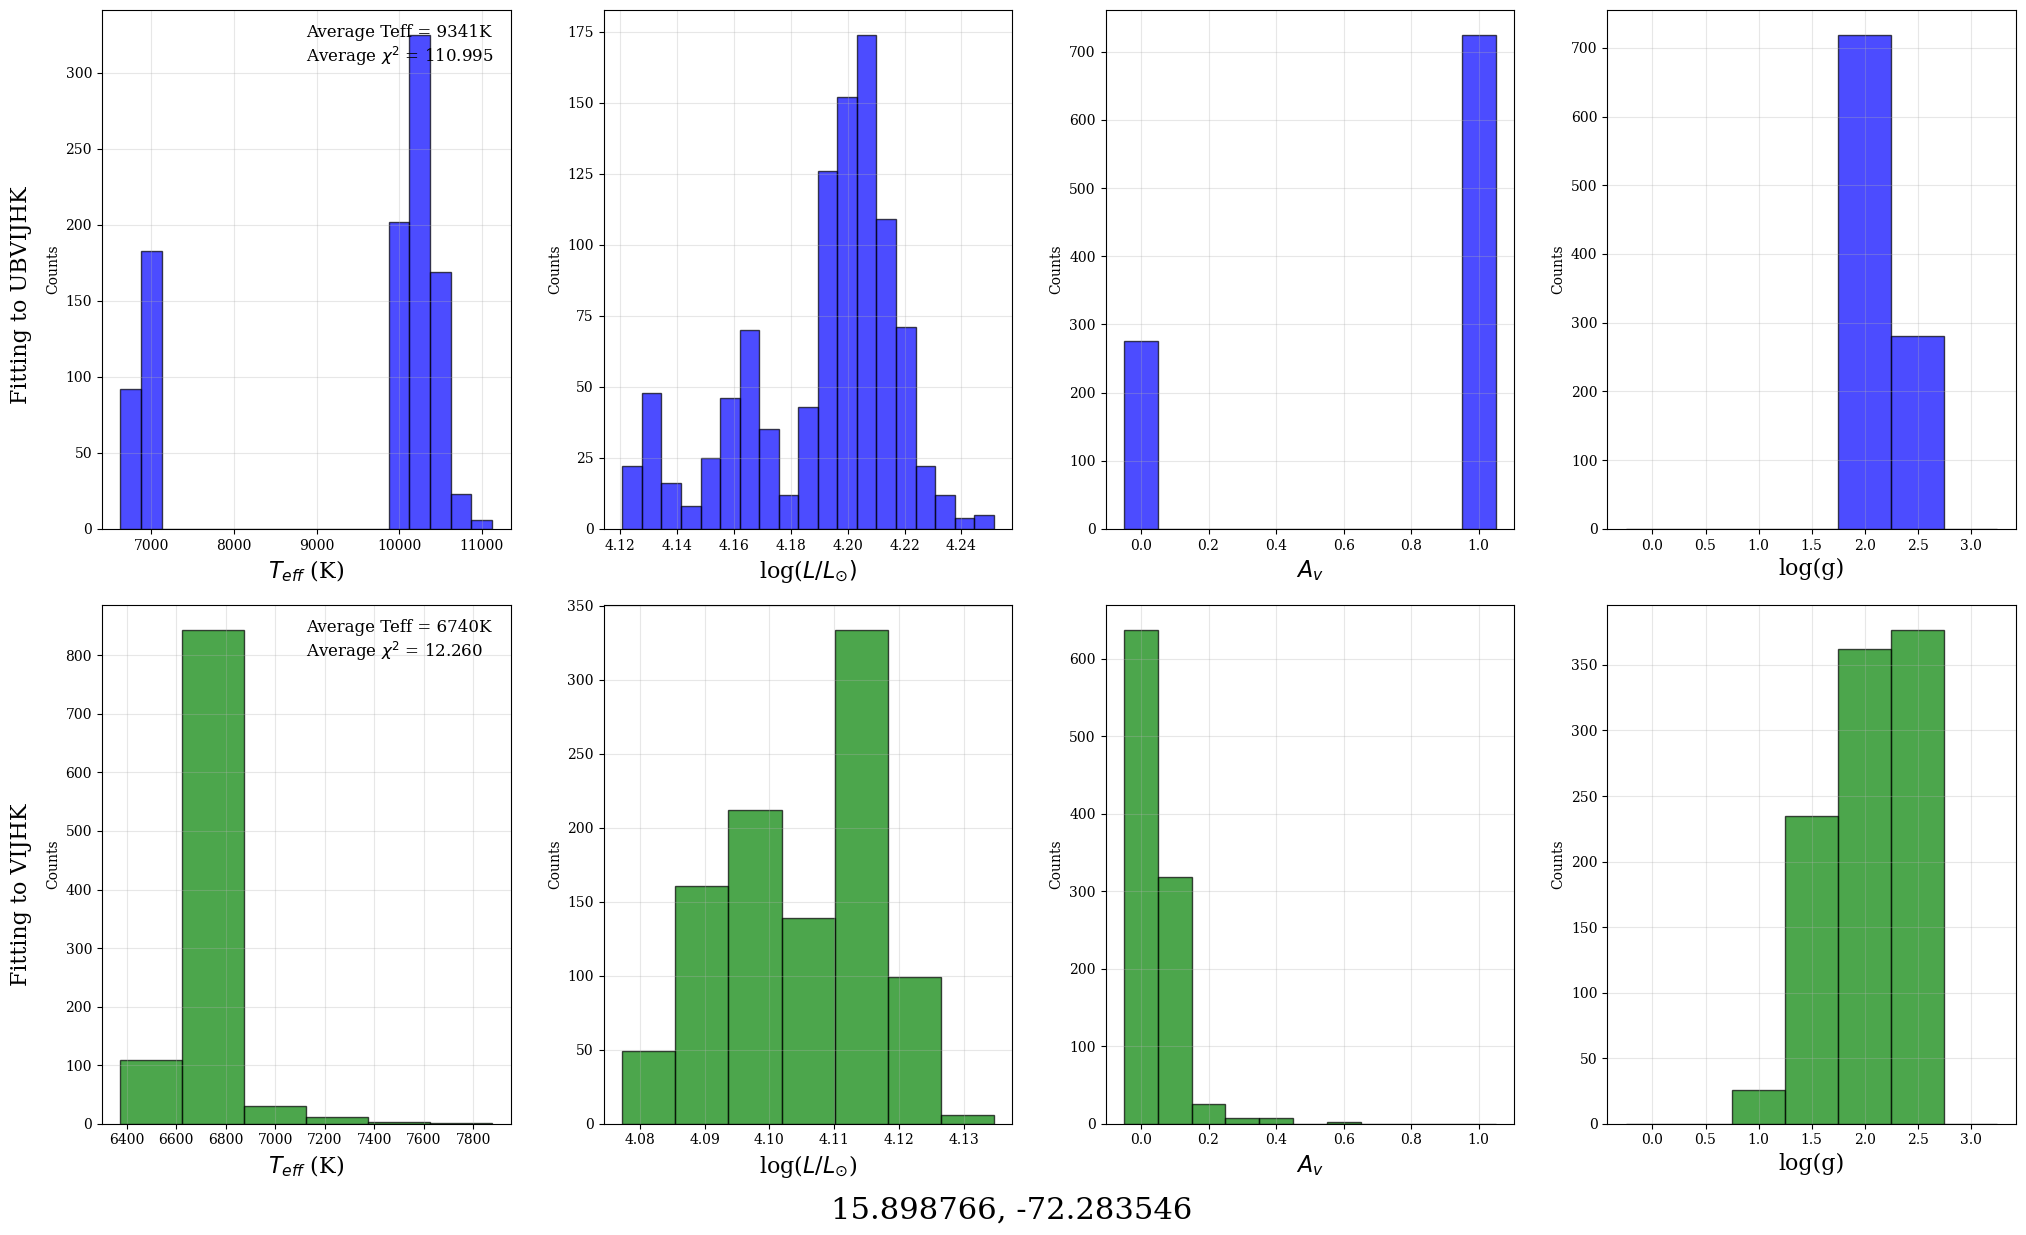

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:167: RuntimeWarning: divide by zero encountered in log10
  ax1.plot(wave['wave'], -2.5 * np.log10(data_cut['newflux']/tmass_k_zp),
/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3997040590.py:192: RuntimeWarning: divide by zero encountered in log10
  ax2.plot(wave['wave'], -2.5 * np.log10(data_full['newflux']/tmass_k_zp),


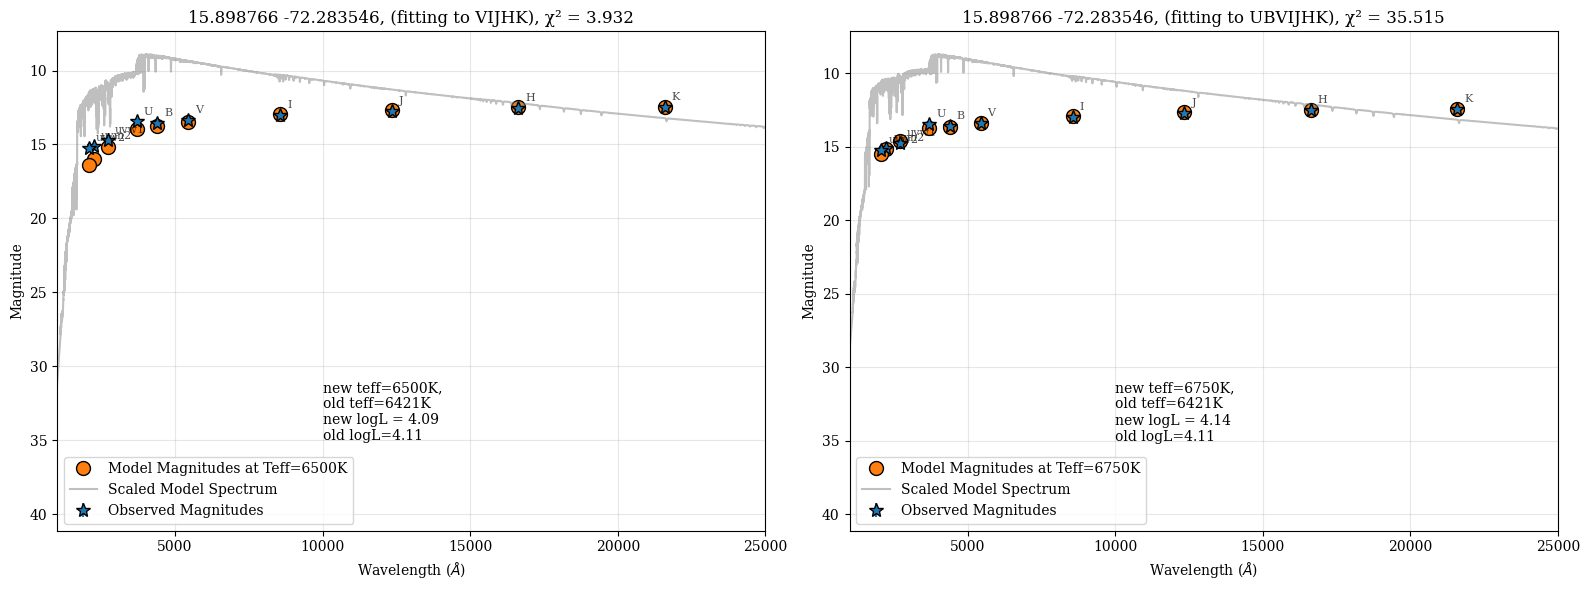

In [58]:
# 685 is an example where fitting to all bands is better
targetstar = 302 # 522, 302
histo(targetstar)
fit_models_to_star(targetstar, show=True)

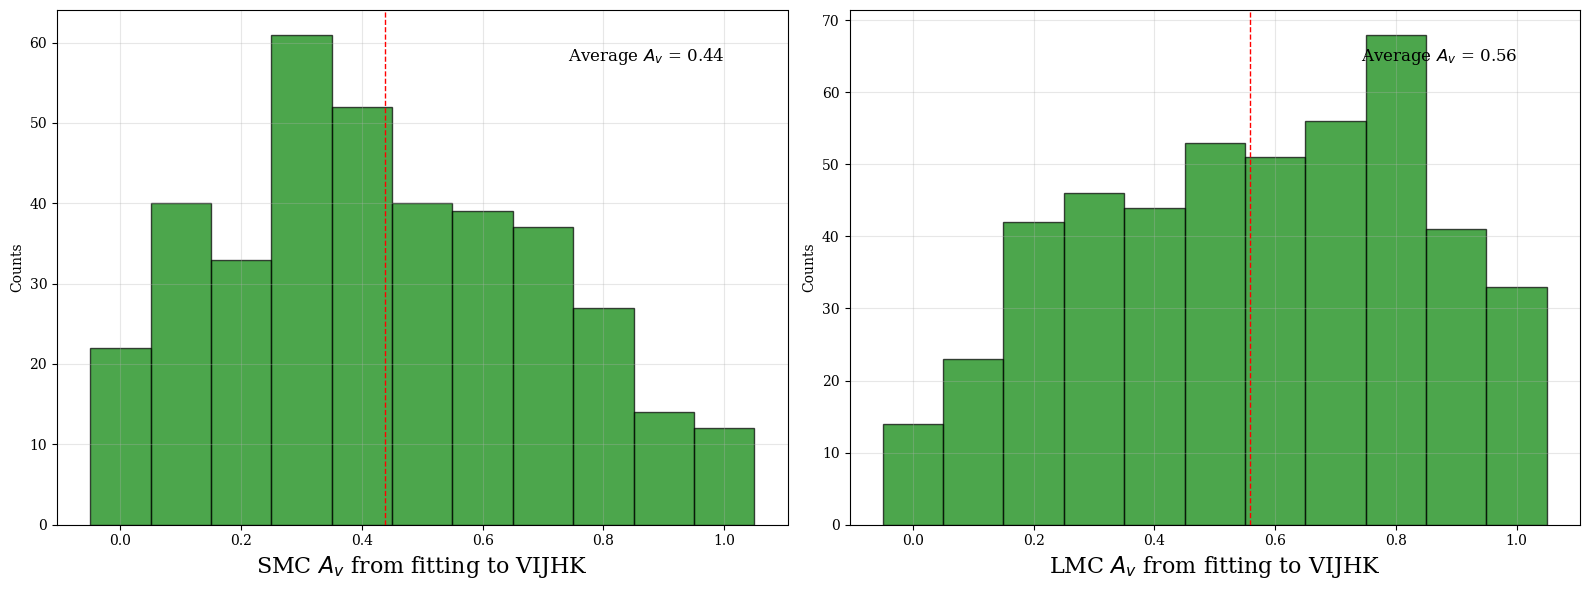

In [59]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

av_bins = np.arange(-0.05, 1.15, 0.1)
ax1.hist(temp_stats['av_mean_cut'][:377], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
ax1.set_xlabel('SMC $A_v$ from fitting to VIJHK', fontsize=16)
average_av_smc = np.mean(temp_stats['av_mean_cut'][:377])
ax1.axvline(average_av_smc, color='red', linestyle='dashed', linewidth=1)
ax1.annotate(f'Average $A_v$ = {average_av_smc:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12)
ax1.set_ylabel('Counts')
ax1.grid(True, alpha=0.3)

ax2.hist(temp_stats['av_mean_cut'][377:], bins=av_bins, color='green', alpha=0.7, edgecolor='black')
ax2.set_xlabel('LMC $A_v$ from fitting to VIJHK', fontsize=16)
average_av_lmc = np.mean(temp_stats['av_mean_cut'][377:])
ax2.axvline(average_av_lmc, color='red', linestyle='dashed', linewidth=1)
ax2.annotate(f'Average $A_v$ = {average_av_lmc:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12)
ax2.set_ylabel('Counts')
ax2.grid(True, alpha=0.3)
# fig.text(0.5,-0.02, 'LMC', fontsize=22)

plt.tight_layout()
plt.show()

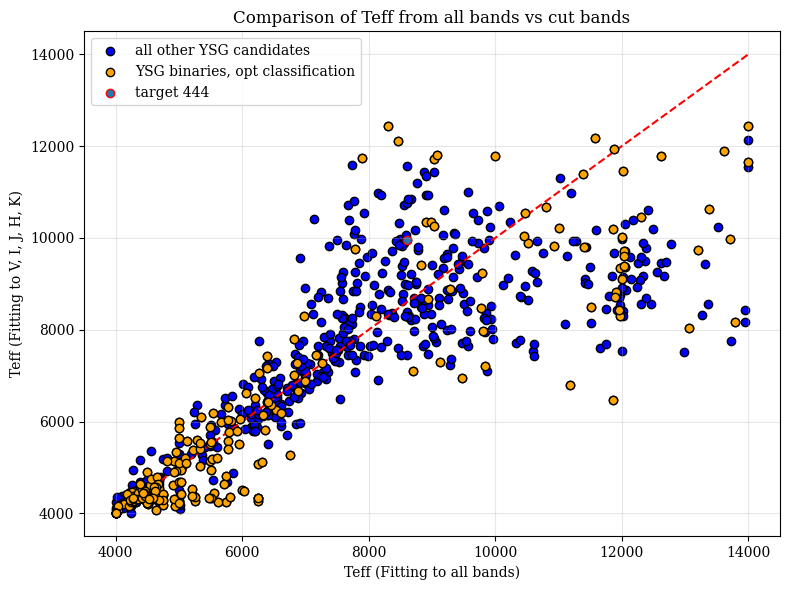

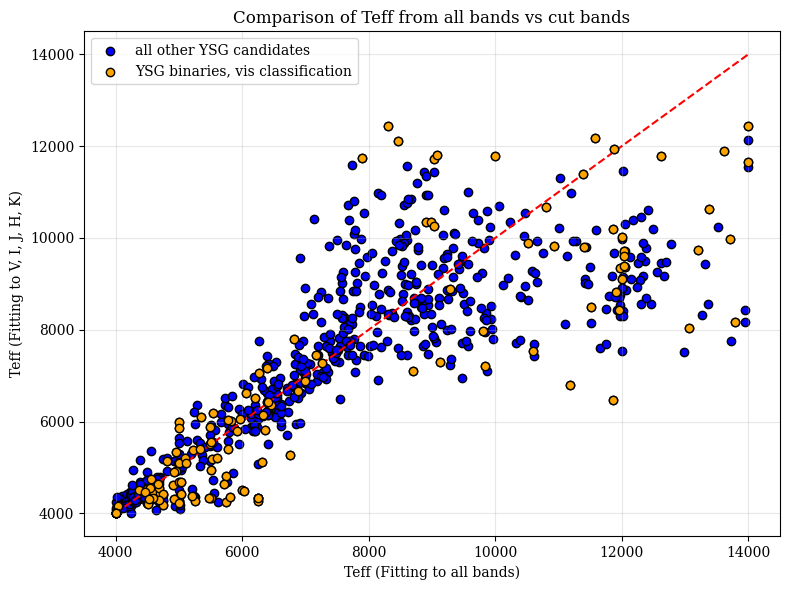

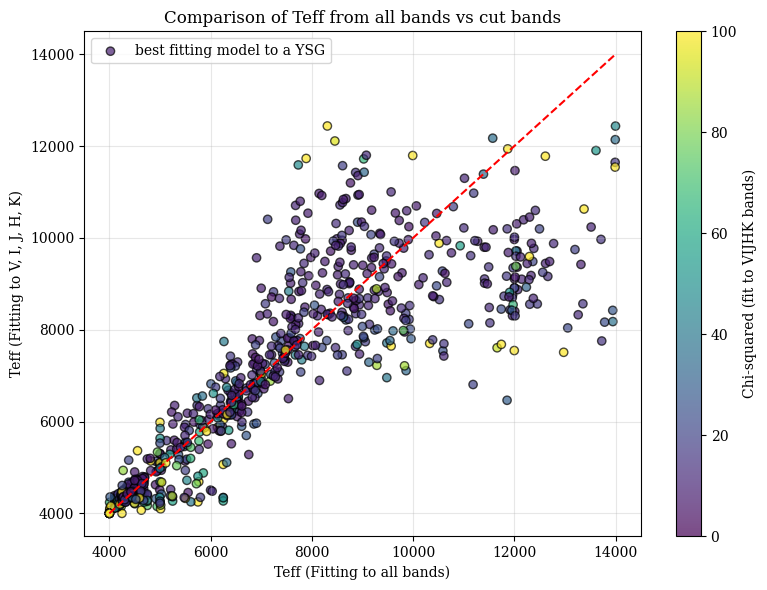

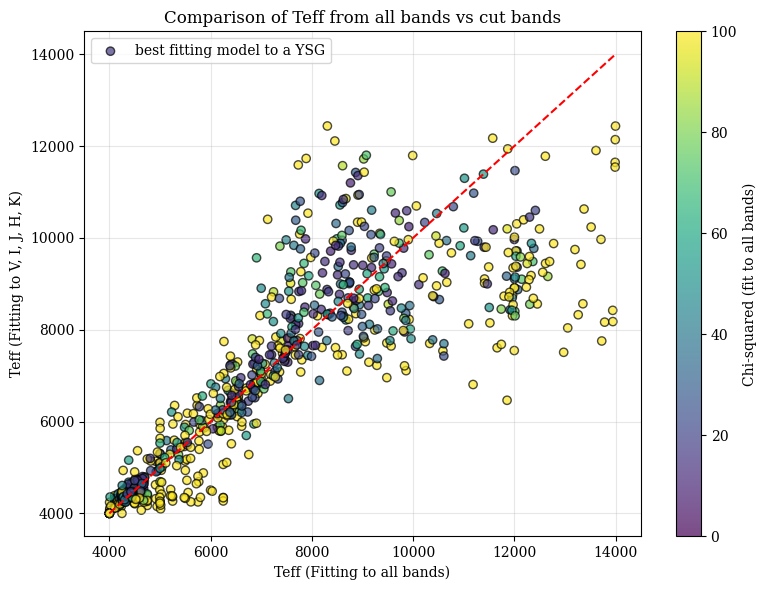

In [60]:
summary_fitting = pd.read_csv('ysg_temp_fitting_summary.csv')
teff_allbands = summary_fitting['teff_mean_full']
teff_cutbands = summary_fitting['teff_mean_cut']
chi2_cut = summary_fitting['chi2_cut_mean']
chi2_full = summary_fitting['chi2_full_mean']

smc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_opt_bin.csv')
lmc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_opt_bin.csv')
all_opt_bin = pd.concat([smc_opt_bin, lmc_opt_bin], ignore_index=True)

smc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_vis_bin.csv')
lmc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_vis_bin.csv')
all_vis_bin = pd.concat([smc_vis_bin, lmc_vis_bin], ignore_index=True)

#match up RAs and decs of all_opt_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_opt_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, opt classification', zorder=10)
ax.scatter(teff_allbands[444], teff_cutbands[444], edgecolor='r', label='target 444')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#match up RAs and decs of all_vis_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_vis_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, vis classification', zorder=10)
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


cbarmin = 0
cbarmax = 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_full, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to all bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

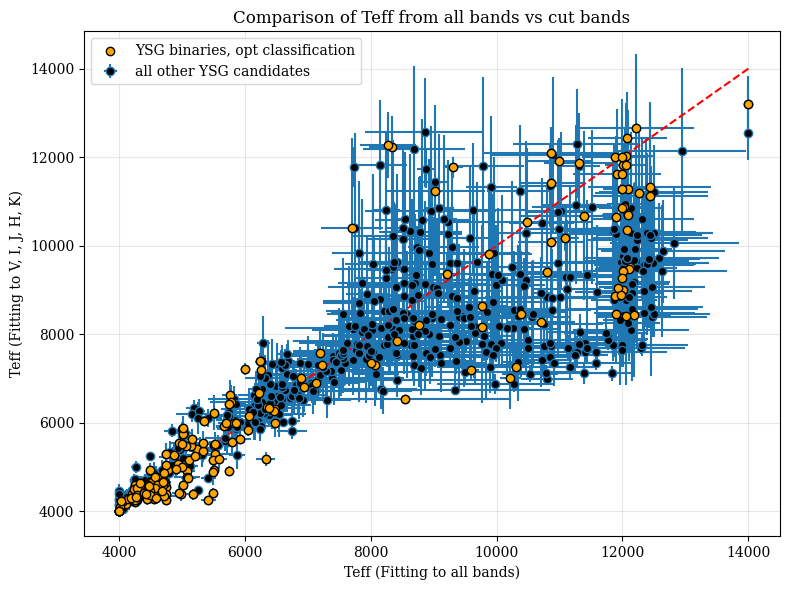

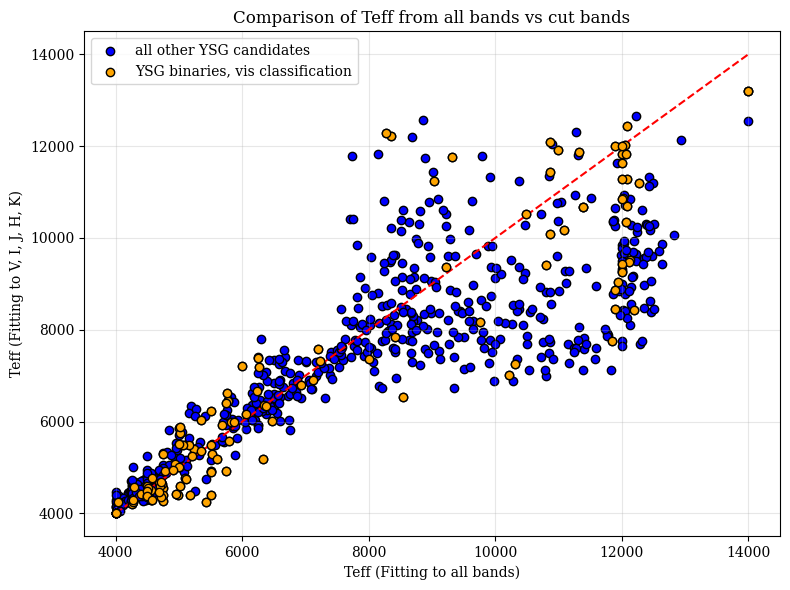

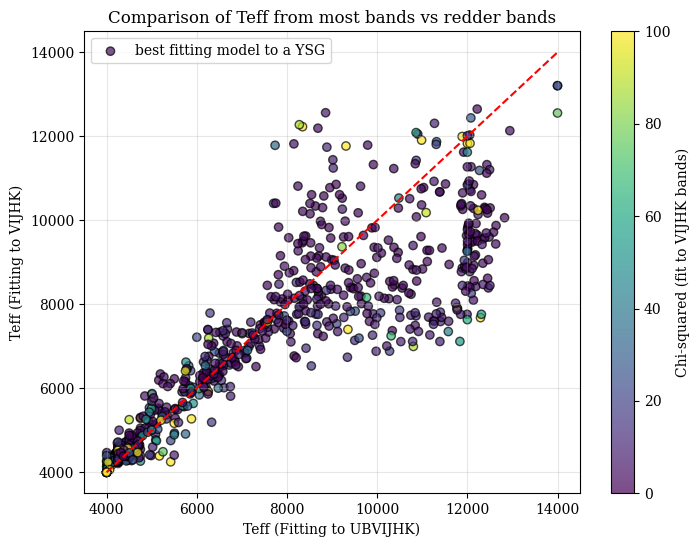

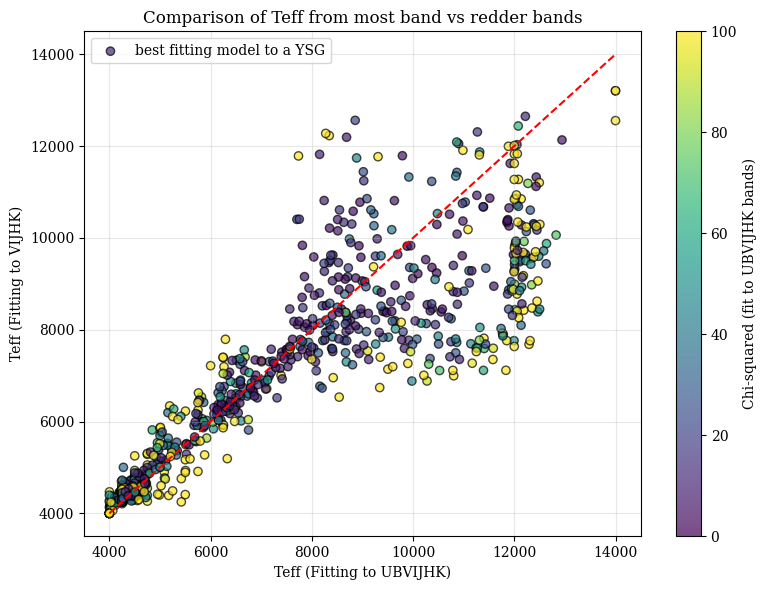

In [82]:
summary_fitting = pd.read_csv('ysg_temp_fitting_summary_v2.csv')
teff_allbands = summary_fitting['teff_mean_full']
teff_cutbands = summary_fitting['teff_mean_cut']
teff_fullstd = summary_fitting['teff_std_full']
teff_cutstd = summary_fitting['teff_std_cut']
chi2_cut = summary_fitting['chi2_cut_mean']
chi2_full = summary_fitting['chi2_full_mean']
# yerr_full = [summary_fitting['chi2_full_mean'] - summary_fitting['teff_16perc_full'], summary_fitting['teff_84perc_full'] - summary_fitting['teff_mean_full']]
xerr_full = [summary_fitting['teff_mean_full'] - summary_fitting['teff_16perc_full'], summary_fitting['teff_84perc_full'] - summary_fitting['teff_mean_full']] 
# yerr_cut = [summary_fitting['logL_mean_cut'] - summary_fitting['logL_16perc_cut'],
#             summary_fitting['logL_84perc_cut'] - summary_fitting['logL_mean_cut']]
yerr_cut = [summary_fitting['teff_mean_cut'] - summary_fitting['teff_16perc_cut'],
            summary_fitting['teff_84perc_cut'] - summary_fitting['teff_mean_cut']]

smc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_opt_bin.csv')
lmc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_opt_bin.csv')
all_opt_bin = pd.concat([smc_opt_bin, lmc_opt_bin], ignore_index=True)

smc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_vis_bin.csv')
lmc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_vis_bin.csv')
all_vis_bin = pd.concat([smc_vis_bin, lmc_vis_bin], ignore_index=True)

#match up RAs and decs of all_opt_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_opt_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.errorbar(teff_allbands, teff_cutbands, xerr=teff_fullstd, yerr=teff_cutstd, c='black', marker='o', ecolor='tab:blue', markeredgecolor='tab:blue', ls='none', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, opt classification', zorder=10)
# ax.scatter(teff_allbands[444], teff_cutbands[444], edgecolor='r', label='target 444')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#match up RAs and decs of all_vis_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_vis_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_mean_full'].values[0])
        matched_teff_cutbands.append(match['teff_mean_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, vis classification', zorder=10)
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


cbarmin = 0
cbarmax = 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most bands vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
plt.grid(True, alpha=0.3)
# plt.tight_layout()
plt.savefig('plot2.png', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_full, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to UBVIJHK)')
ax.set_ylabel('Teff (Fitting to VIJHK)')
ax.set_title('Comparison of Teff from most band vs redder bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to UBVIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/4281504754.py:17: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


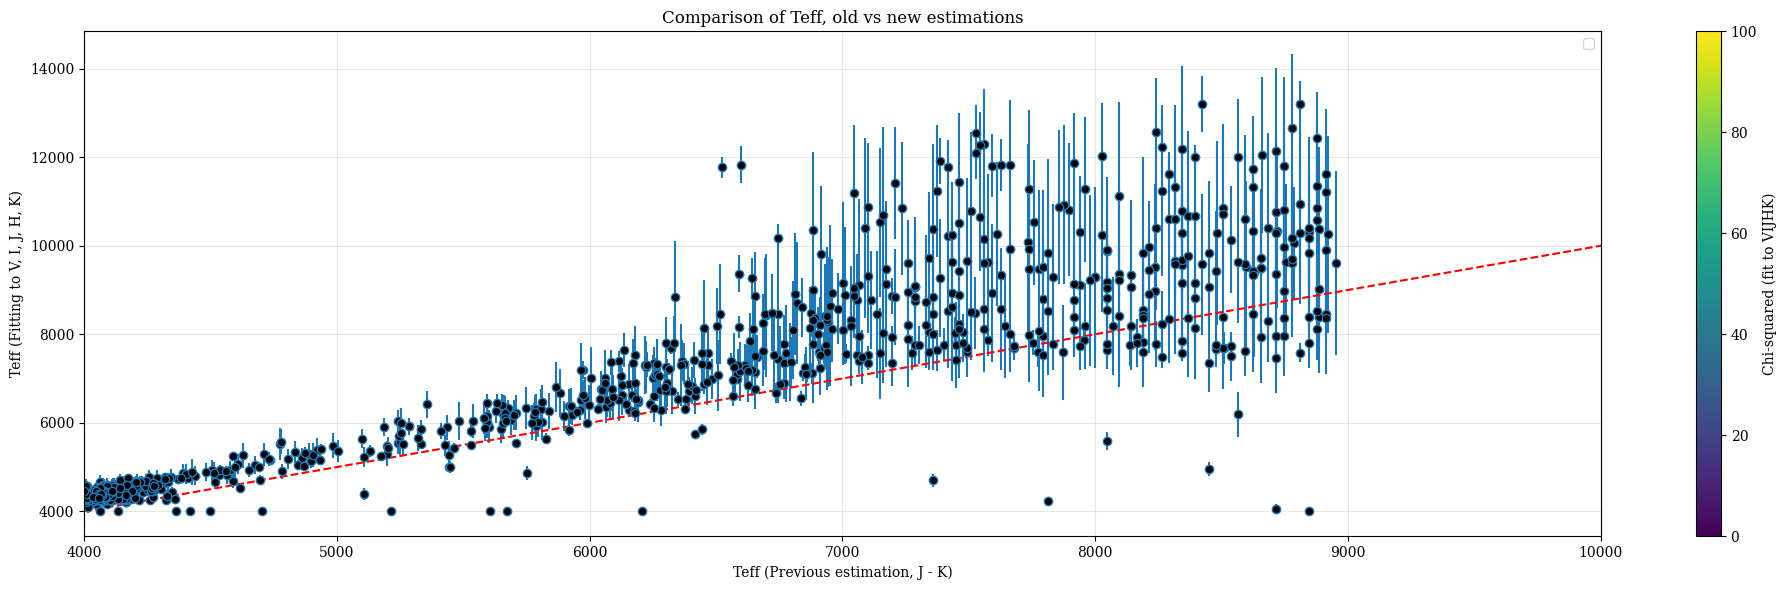

In [62]:
fig, ax = plt.subplots(figsize=(20, 6))

summary_fitting = pd.read_csv('ysg_temp_fitting_summary_v2.csv')
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
teff_cutbands = summary_fitting['teff_mean_cut']
teff_cutstd = summary_fitting['teff_std_cut']
chi2_cut = summary_fitting['chi2_cut_mean']

# ax.scatter(10**x_old, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.errorbar(10**x_old, teff_cutbands, yerr=teff_cutstd, c='black', marker='o', ecolor='tab:blue', markeredgecolor='tab:blue', ls='none')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Previous estimation, J - K)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff, old vs new estimations')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK)')
plt.xlim(4000,10000)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [63]:
print(np.mean(teff_cutstd))
print(np.mean(teff_fullstd))

yerr_cut = [summary_fitting['teff_mean_cut'] - summary_fitting['teff_16perc_cut'],
            summary_fitting['teff_84perc_cut'] - summary_fitting['teff_mean_cut']]

print([i for i in yerr_cut if (i < 0).any()])

589.7498261168952
320.62064840451353
[0      174.25
1      402.00
2      127.25
3       23.75
4      -16.50
        ...  
843    648.50
844    128.50
845    625.00
846    552.00
847    351.75
Length: 848, dtype: float64, 0       75.75
1      348.00
2      122.75
3      226.25
4       16.50
        ...  
843    351.50
844    121.50
845    625.00
846    448.00
847    148.25
Length: 848, dtype: float64]


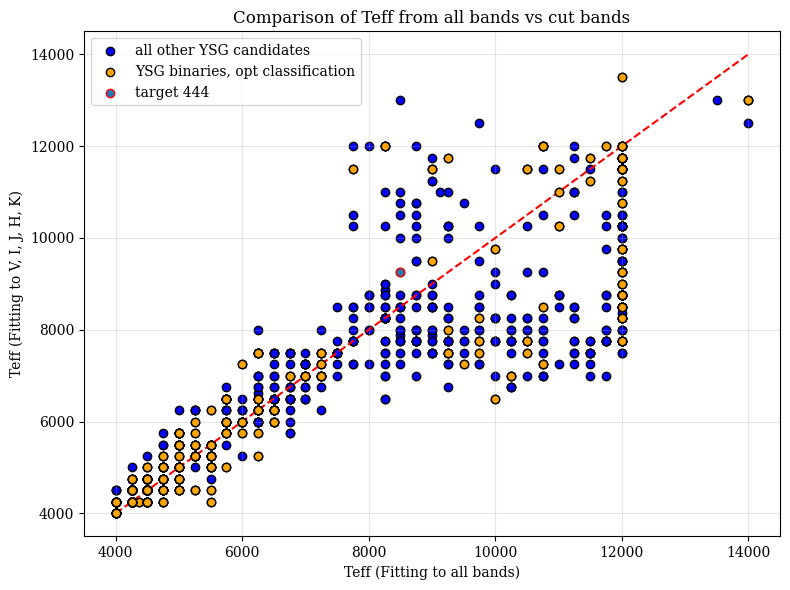

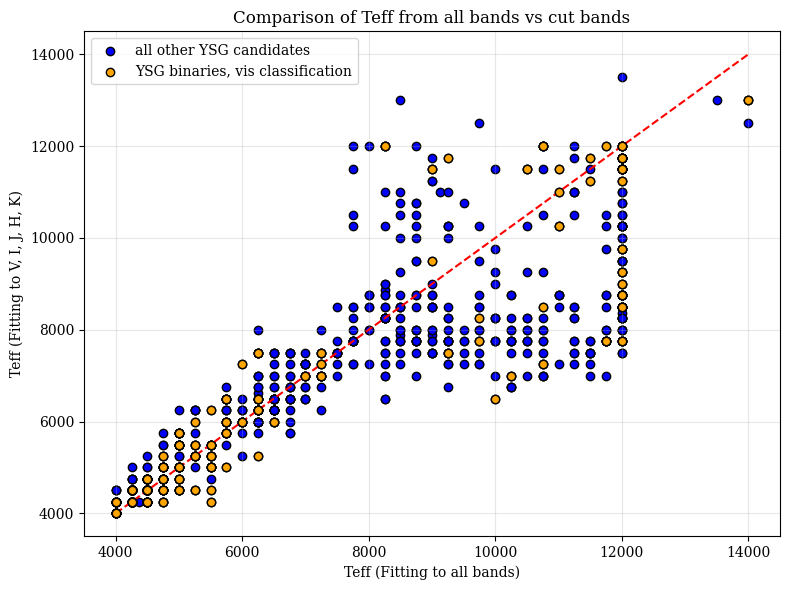

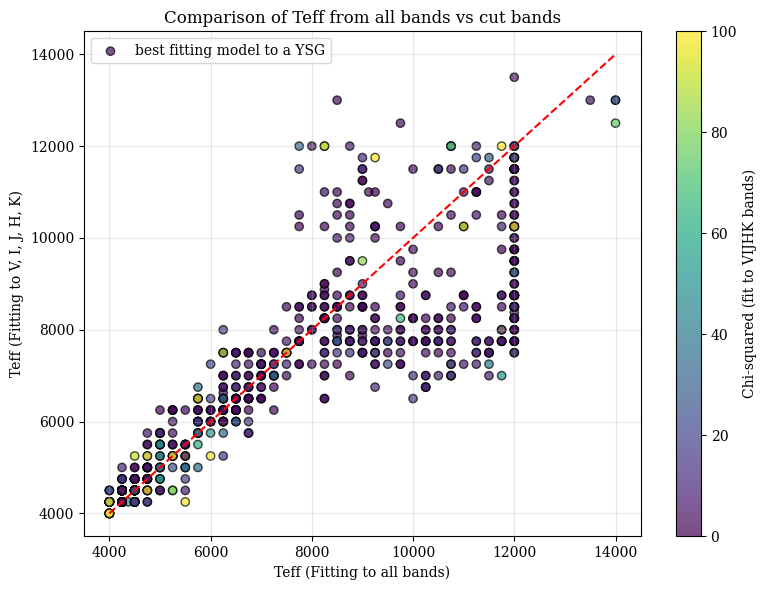

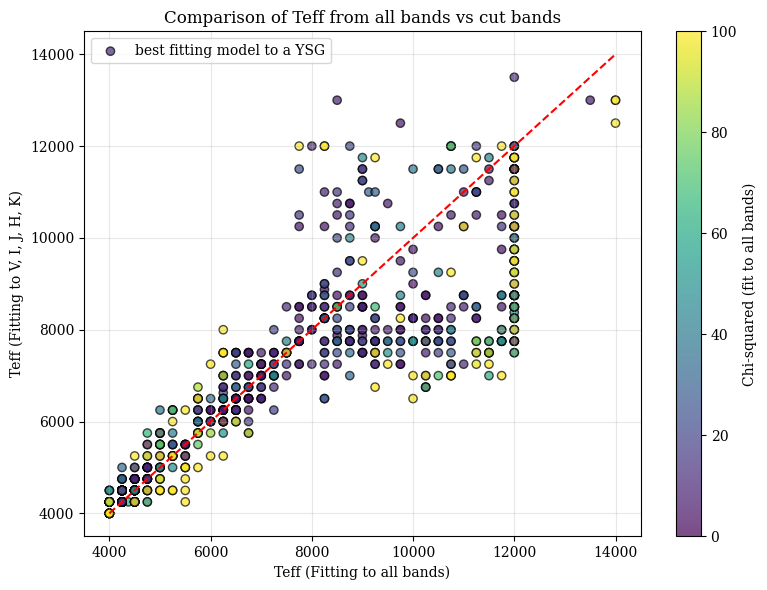

In [64]:
summary_fitting = pd.read_csv('ysg_temp_fitting_summary_v2.csv')
teff_allbands = summary_fitting['teff_median_full']
teff_cutbands = summary_fitting['teff_median_cut']
chi2_cut = summary_fitting['chi2_cut_mean']
chi2_full = summary_fitting['chi2_full_mean']
yerr_full = summary_fitting['teff_16perc_full'], summary_fitting['teff_84perc_full']
xerr_full = summary_fitting['teff_16perc_full'], summary_fitting['teff_84perc_full'] 
yerr_cut = summary_fitting['teff_16perc_cut'], summary_fitting['teff_84perc_cut']
xerr_cut = summary_fitting['teff_16perc_cut'], summary_fitting['teff_84perc_cut'] 

smc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_opt_bin.csv')
lmc_opt_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_opt_bin.csv')
all_opt_bin = pd.concat([smc_opt_bin, lmc_opt_bin], ignore_index=True)

smc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/smc_vis_bin.csv')
lmc_vis_bin = pd.read_csv('/Users/shannonbowes/Research/ysg/candidates_and_lcs/lmc_vis_bin.csv')
all_vis_bin = pd.concat([smc_vis_bin, lmc_vis_bin], ignore_index=True)

#match up RAs and decs of all_opt_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_opt_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_median_full'].values[0])
        matched_teff_cutbands.append(match['teff_median_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, opt classification', zorder=10)
ax.scatter(teff_allbands[444], teff_cutbands[444], edgecolor='r', label='target 444')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


#match up RAs and decs of all_vis_bin to summary_fitting
matched_teff_allbands = []
matched_teff_cutbands = []
matched_chi2_cut = []
matched_chi2_full = []
for i, row in all_vis_bin.iterrows():
    ra = row['ra']
    dec = row['dec']
    match = summary_fitting[(summary_fitting['RA'] == ra) & (summary_fitting['DEC'] == dec)]
    if not match.empty:
        matched_teff_allbands.append(match['teff_median_full'].values[0])
        matched_teff_cutbands.append(match['teff_median_cut'].values[0])
        matched_chi2_cut.append(match['chi2_cut_mean'].values[0])
        matched_chi2_full.append(match['chi2_full_mean'].values[0])

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c='blue', edgecolor='k', label='all other YSG candidates')
ax.scatter(matched_teff_allbands, matched_teff_cutbands, c='orange', edgecolor='k', label='YSG binaries, vis classification', zorder=10)
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


cbarmin = 0
cbarmax = 100

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(teff_allbands, teff_cutbands, c=chi2_full, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Fitting to all bands)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff from all bands vs cut bands')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to all bands)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

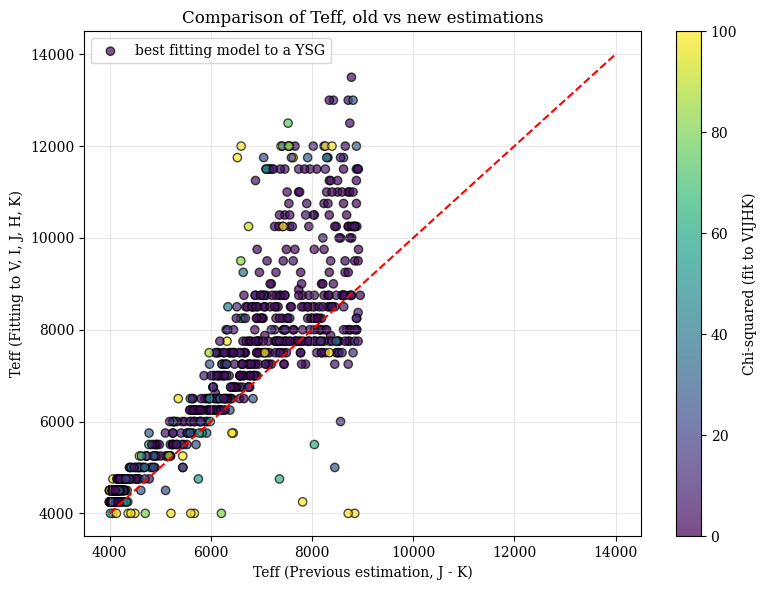

In [65]:
fig, ax = plt.subplots(figsize=(8, 6))

periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']

ax.scatter(10**x_old, teff_cutbands, c=chi2_cut, edgecolor='k', alpha=0.7, label='best fitting model to a YSG')
ax.plot([min(teff_allbands), max(teff_allbands)], [min(teff_allbands), max(teff_allbands)], 'r--')
ax.set_xlabel('Teff (Previous estimation, J - K)')
ax.set_ylabel('Teff (Fitting to V, I, J, H, K)')
ax.set_title('Comparison of Teff, old vs new estimations')
ax.legend()
cbar = plt.colorbar(ax.collections[0], ax=ax)
ax.collections[0].set_clim(cbarmin, cbarmax)
cbar.set_label('Chi-squared (fit to VIJHK)')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [66]:
counter = 0
for row in summary_fitting.itertuples():
    if row.chi2_full_mean < row.chi2_cut_mean:
        counter += 1
print(f'Number of stars where fitting to all bands is better: {counter} out of {len(summary_fitting)}')

Number of stars where fitting to all bands is better: 0 out of 848


/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/2525353345.py:44: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1 = ax1.scatter(x_old, y_old, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')


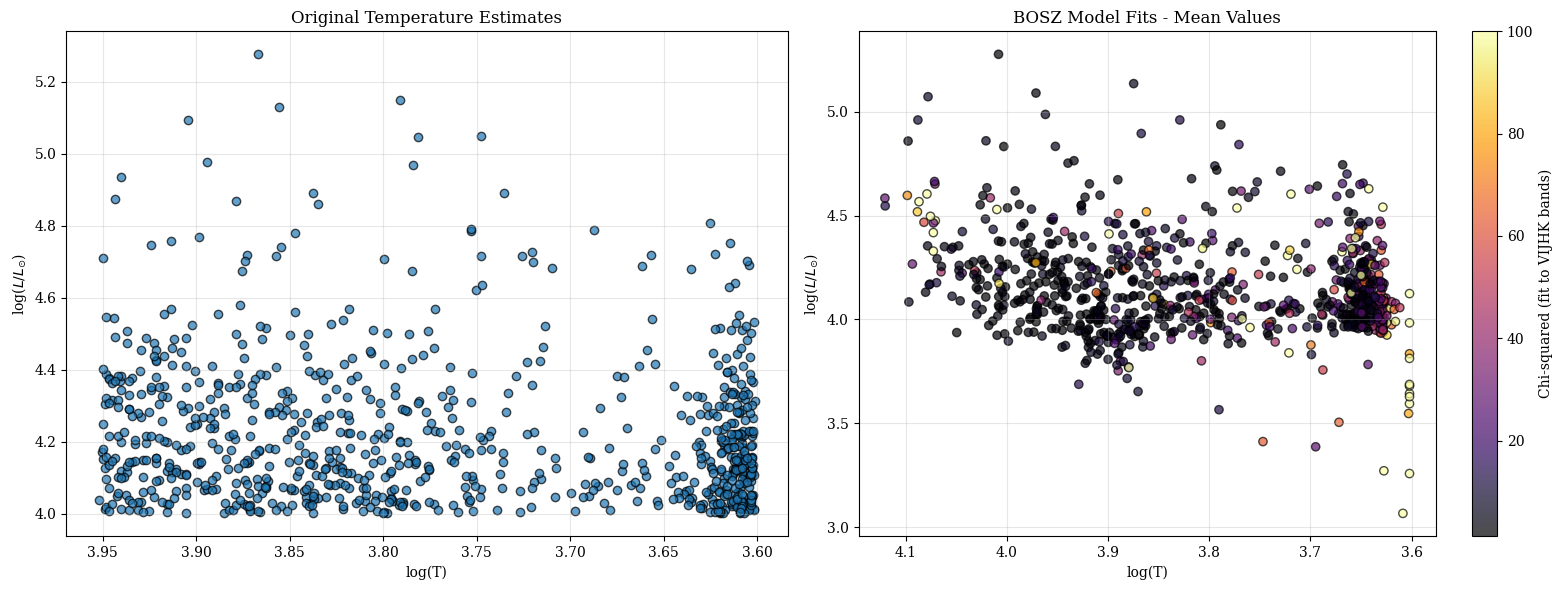

In [67]:
# temp_stats = pd.read_csv('ysg_temp_fitting_summary.csv')

# logT = temp_stats['logT_mean_cut']
# logL = temp_stats['logL_mean_cut']

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# # Old estimations
# periods = stats['best_period']
# x_old = stats['logT']
# y_old = stats['logL']
# sc1 = ax1.scatter(x_old, y_old, c=periods, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
# ax1.set_xlabel('log(T)')
# ax1.set_ylabel('log($L/L_{\\odot}$)')
# ax1.set_title('Original Temperature Estimates')
# ax1.invert_xaxis()
# ax1.grid(True, alpha=0.3)

# sc = ax2.scatter(logT, logL, c=periods, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno')
# sc2 = ax2.scatter(logT.iloc[444], logL.iloc[444], c='red', edgecolor='k', label='target star 444')
# sc2 = ax2.scatter(logT.iloc[726], logL.iloc[726], c='red', edgecolor='k', label='target star 726')
# ax2.set_xlabel('log(T)')
# ax2.set_ylabel('log($L/L_{\\odot}$)')
# ax2.set_title('BOSZ Model Fits - Mean Values')
# ax2.invert_xaxis()
# ax2.grid(True, alpha=0.3)
# cbar = plt.colorbar(sc, ax=ax2)
# cbar.set_label('Period (days)')
# plt.tight_layout()
# plt.show()

temp_stats = pd.read_csv('ysg_temp_fitting_summary_v2.csv')

logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']
chi2_cut = temp_stats['chi2_cut_mean']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']
sc1 = ax1.scatter(x_old, y_old, edgecolor='k', label='old estimations', alpha=0.7, cmap='inferno')
ax1.set_xlabel('log(T)')
ax1.set_ylabel('log($L/L_{\\odot}$)')
ax1.set_title('Original Temperature Estimates')
ax1.invert_xaxis()
ax1.grid(True, alpha=0.3)

sc = ax2.scatter(logT, logL, c=chi2_cut, edgecolor='k', label='new estimations', alpha=0.7, cmap='inferno', vmax=100)
# sc2 = ax2.scatter(logT.iloc[444], logL.iloc[444], c='red', edgecolor='k', label='target star 444')
# sc2 = ax2.scatter(logT.iloc[726], logL.iloc[726], c='red', edgecolor='k', label='target star 726')
ax2.set_xlabel('log(T)')
ax2.set_ylabel('log($L/L_{\\odot}$)')
ax2.set_title('BOSZ Model Fits - Mean Values')
ax2.invert_xaxis()
ax2.grid(True, alpha=0.3)
cbar = plt.colorbar(sc, ax=ax2)
cbar.set_label('Chi-squared (fit to VIJHK bands)')
# cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()

/var/folders/34/3847lqd14j78mfm70_z1c_r00000gn/T/ipykernel_78183/3018782982.py:70: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend()


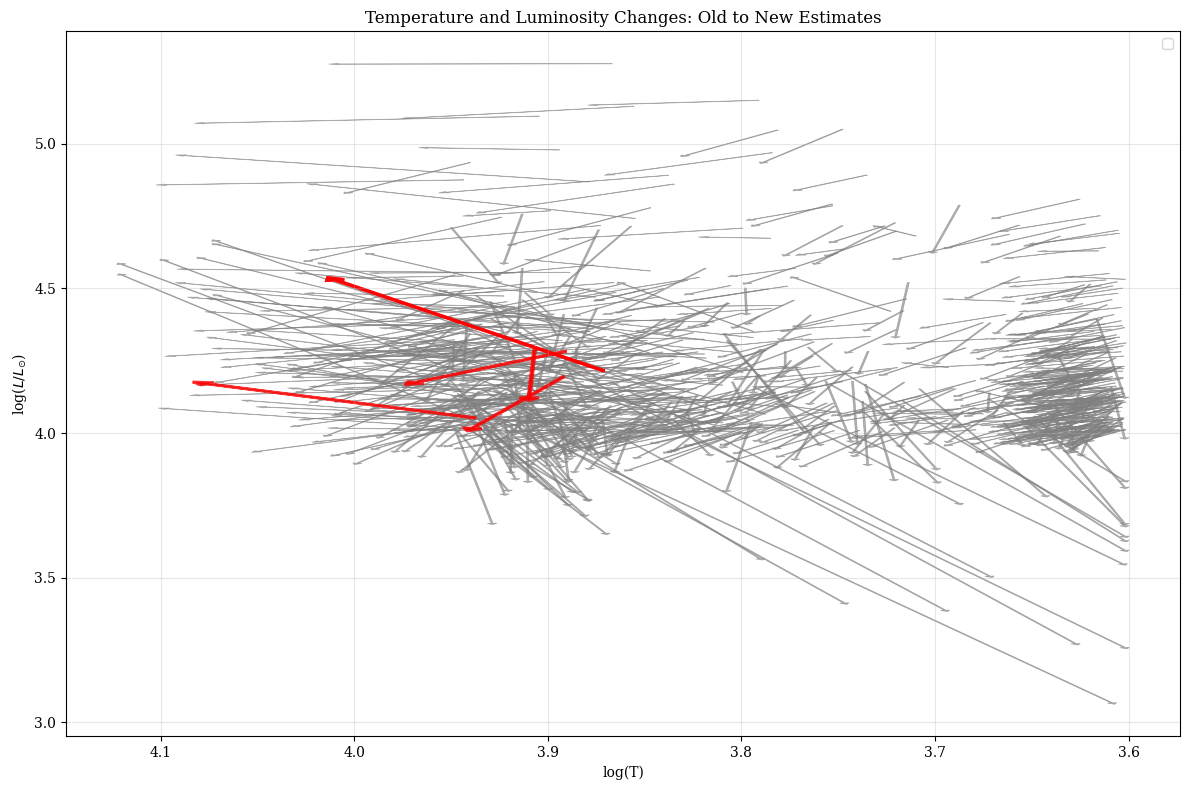

In [68]:
temp_stats = pd.read_csv('ysg_temp_fitting_summary_v2.csv')

logT = temp_stats['logT_mean_cut']
logL = temp_stats['logL_mean_cut']

# Old estimations
periods = stats['best_period']
x_old = stats['logT']
y_old = stats['logL']

fig, ax = plt.subplots(1, 1, figsize=(12, 8))

# # Plot old positions as starting points
# sc1 = ax.scatter(x_old, y_old, c=periods, edgecolor='k', label='Old estimations', 
#                 alpha=0.7, cmap='inferno', s=50, marker='o')

# # Plot new positions as ending points
# sc2 = ax.scatter(logT, logL, c=periods, edgecolor='k', label='New estimations', 
#                 alpha=0.7, cmap='inferno', s=50, marker='^')

for i in range(len(x_old)):
    dx = logT.iloc[i] - x_old.iloc[i]
    dy = logL.iloc[i] - y_old.iloc[i]

    ax.arrow(x_old.iloc[i], y_old.iloc[i], dx, dy,
            head_width=0.005, head_length=0.005, 
            fc='gray', ec='gray', alpha=0.6, linewidth=0.5)

dx_444 = logT.iloc[444] - x_old.iloc[444]
dy_444 = logL.iloc[444] - y_old.iloc[444]
ax.arrow(x_old.iloc[444], y_old.iloc[444], dx_444, dy_444,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_726 = logT.iloc[726] - x_old.iloc[726]
dy_726 = logL.iloc[726] - y_old.iloc[726]
ax.arrow(x_old.iloc[726], y_old.iloc[726], dx_726, dy_726,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_495 = logT.iloc[495] - x_old.iloc[495]
dy_495 = logL.iloc[495] - y_old.iloc[495]
ax.arrow(x_old.iloc[495], y_old.iloc[495], dx_495, dy_495,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_802 = logT.iloc[802] - x_old.iloc[802]
dy_802 = logL.iloc[802] - y_old.iloc[802]
ax.arrow(x_old.iloc[802], y_old.iloc[802], dx_802, dy_802,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)

dx_802 = logT.iloc[802] - x_old.iloc[802]
dy_802 = logL.iloc[802] - y_old.iloc[802]
ax.arrow(x_old.iloc[802], y_old.iloc[802], dx_802, dy_802,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)
dx_79 = logT.iloc[79] - x_old.iloc[79]
dy_79 = logL.iloc[79] - y_old.iloc[79]
ax.arrow(x_old.iloc[79], y_old.iloc[79], dx_79, dy_79,
        head_width=0.01, head_length=0.01, 
        fc='red', ec='red', alpha=0.8, linewidth=2)


ax.set_xlabel('log(T)')
ax.set_ylabel('log($L/L_{\\odot}$)')
ax.set_title('Temperature and Luminosity Changes: Old to New Estimates')
ax.invert_xaxis()
ax.grid(True, alpha=0.3)
ax.legend()

# cbar = plt.colorbar(sc1, ax=ax)
# cbar.set_label('Period (days)')
plt.tight_layout()
plt.show()

DEBUG: Star index 60
DEBUG: Target FULL parameters - Teff: 11750.0, logg: 2.5, av: 0.5, metallicity: -0.75
DEBUG: Target CUT parameters - Teff: 8750.0, logg: 2.5, av: 0.3, metallicity: -0.75
DEBUG: Total models in computed_models: 2662
DEBUG: Computed models columns: ['model', 'teff', 'logg', 'atmos', 'metallicity', 'av', 'lum_unscaled', 'J_mag', 'H_mag', 'K_mag', 'U_mag', 'B_mag', 'V_mag', 'I_mag', 'uvm2_mag', 'uvw1_mag', 'uvw2_mag', 'J_flux', 'H_flux', 'K_flux', 'U_flux', 'B_flux', 'V_flux', 'I_flux', 'uvm2_flux', 'uvw1_flux', 'uvw2_flux']
DEBUG: Unique Teff values in models: [np.int64(4000), np.int64(4250), np.int64(4500), np.int64(4750), np.int64(5000), np.int64(5250), np.int64(5500), np.int64(5750), np.int64(6000), np.int64(6250), np.int64(6500), np.int64(6750), np.int64(7000), np.int64(7250), np.int64(7500), np.int64(7750), np.int64(8000), np.int64(8250), np.int64(8500), np.int64(8750), np.int64(9000), np.int64(9250), np.int64(9500), np.int64(9750), np.int64(10000), np.int64(1025

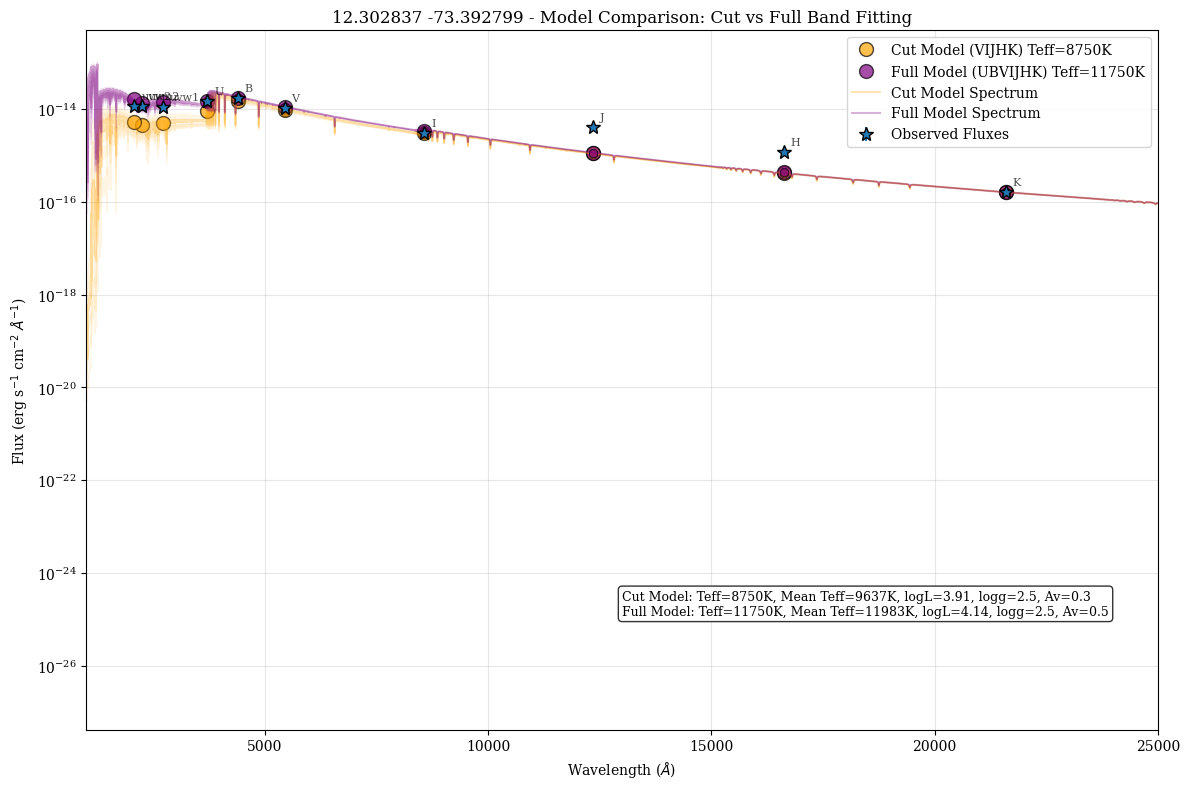

[{'model_type': 'cut',
  'model': model           /Users/shannonbowes/Research/ysg/candidates_an...
  teff                                                         8750
  logg                                                          2.5
  atmos                                                          ap
  metallicity                                                 -0.75
  av                                                            0.3
  lum_unscaled    8874491132394848044529001481474335860726242648...
  J_mag                                                  -37.493635
  H_mag                                                  -37.561978
  K_mag                                                  -37.570857
  U_mag                                                  -36.971457
  B_mag                                                  -37.097427
  V_mag                                                  -37.190573
  I_mag                                                  -37.399328
  uvm2_mag      

In [84]:
fit_models_to_star_flux(star_idx=60, show=True) #743, 533